<a href="https://colab.research.google.com/github/hiendinh2001/Traveling_Salesman_Problem_Simulated_Annealing/blob/main/test_TP_TSP_SA_DINHThiThuHien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Module : Méthodes d’Optimisation Avancées**
# **Travaux Pratiques - Problème du Voyageur de Commerce (TSP) avec Recuit Simulé (SA)**

## **Objectif**
Ce programme résout le problème du voyageur de commerce (Traveling Salesman Problem – TSP) en utilisant l'algorithme du Recuit Simulé (Simulated Annealing – SA).

## **Étapes à réaliser/coder**

1. Choix des structures de données pour le codage d’une solution (justifier).
2. Lecture d’un fichier d’entrée issu de la bibliothèque TSPLIB95 –voir les liens ci‐dessous‐,
(exemple d’un fichier d’entrée : Berlin52.tsp ou autres).
3. Codage des différentes étapes de SA à savoir ; l’initialisation, la génération de voisinage, le choix
d’une solution voisine, l’évaluation, etc.
4. Affichage des résultats : la solution optimale trouvée et pour chaque itération, la solution trouvée.

## **Liens des benchmarks (fichiers d’entrée)**

http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/

http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html

http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

### **Etape 1 : Importation des bibliothèques et modules nécessaires**

In [16]:
import random
import math
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import os

### **Etape 2 : Lecture du fichier d'entrée**

In [17]:
# Monter le lecteur Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Fonction pour lire le fichier tsp depuis TSPLIB
def read_tsp_file(file_path):
  with open(file_path, 'r') as file:
    lines = file.readlines()

    # Recherche des coordonnées des villes dans le fichier TSPLIB
    start_index = lines.index("NODE_COORD_SECTION\n") + 1
    end_index = lines.index("EOF\n")
    city_data = [list(map(float, line.split()[1:])) for line in lines[start_index:end_index]]

    # Conversion des coordonnées des villes en un tableau numpy
    cities = [(i+1, coords) for i, coords in enumerate(city_data)]
    return cities

# Exemple d'utilisation de la fonction read_tsp_file
file_path = "/content/drive/MyDrive/Colab Notebooks/TSP_SA/berlin52.tsp"
cities = read_tsp_file(file_path)[:5]

# Affichage des villes
print("Villes :")
for city_id, coordinates in cities:
    print(f"Ville {city_id} - Coordonnées : {coordinates}")

Villes :
Ville 1 - Coordonnées : [565.0, 575.0]
Ville 2 - Coordonnées : [25.0, 185.0]
Ville 3 - Coordonnées : [345.0, 750.0]
Ville 4 - Coordonnées : [945.0, 685.0]
Ville 5 - Coordonnées : [845.0, 655.0]


### **Etape 3 : Initialisation de la solution aléatoire**
Le code suivant représente la fonction qui initialise une solution aléatoire pour le problème du Voyageur de Commerce.


In [19]:
# Fonction pour initialiser une solution aléatoire
def initialize_solution(cities):

  # Sélectionner la première ville comme point de départ
  start = cities[0]

  # Exclure la première ville lors du mélange du reste des données
  rest_of_cities = cities[1:]
  random.shuffle(rest_of_cities)

  # Créer la solution en ajoutant la première ville au début et à la fin
  solution = [start] + rest_of_cities + [start]
  return solution

# Exemple d'utilisation de la fonction initialize_solution
initial_solution = initialize_solution(cities)
print("Solution initiale :")
for city_id, coordinates in initial_solution:
    print(f"Ville {city_id} - Coordonnées : {coordinates}")

Solution initiale :
Ville 1 - Coordonnées : [565.0, 575.0]
Ville 5 - Coordonnées : [845.0, 655.0]
Ville 2 - Coordonnées : [25.0, 185.0]
Ville 4 - Coordonnées : [945.0, 685.0]
Ville 3 - Coordonnées : [345.0, 750.0]
Ville 1 - Coordonnées : [565.0, 575.0]


### **Etape 4 : Calcul des distances et de la longueur totale**
Deux fonctions sont définies pour calculer les distances entre les villes et la longueur totale d'un parcours.


In [20]:
# Fonction pour calculer la distance entre deux villes
def calculate_distance(city1, city2):

  # Extraire les coordonnées x, y de chaque ville
  x1, y1 = city1[1]
  x2, y2 = city2[1]

  # Utiliser la formule de distance euclidienne
  return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Fonction pour calculer la longueur totale d'un parcours
def calculate_total_length(solution):
  total_length = 0

  # Parcourir chaque paire de villes consécutives dans la solution
  for i in range(len(solution) - 1):
    # Ajouter la distance entre les villes à la longueur totale
    total_length += calculate_distance(solution[i], solution[i+1])
  return total_length

# Exemple d'utilisation de la fonction calculate_total_length
print("Longueur de la solution initiale :", calculate_total_length(initial_solution))

Longueur de la solution initiale : 3168.0655152587715


### **Etape 5 : Génération du voisinage**
Une fonction est définie pour générer un voisinage en inversant deux villes dans le parcours actuel. Trois opérations différentes sont utilisées : swap, insert, et reverse.


In [21]:
# Fonction pour générer un voisinage en inversant deux villes dans le parcours
def generate_neighbor(solution):
  new_solution = solution.copy()

  # Choisir aléatoirement une opération parmi swap, insert, et reverse
  op = random.choice(["swap", "insert", "reverse"])

  if op == "swap":

    # Sélectionner deux indices aléatoires, évitant le début et la fin du parcours
    i, j = np.random.choice(range(1, len(new_solution) - 1), 2, replace=False)

    # Effectuer l'échange des deux villes
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]

  elif op == "insert":

    # Sélectionner deux indices aléatoires, évitant le début et la fin du parcours
    i, j = np.random.choice(range(1, len(new_solution) - 1), 2, replace=False)

    # Retirer une ville à l'indice i et l'insérer à l'indice j
    city_to_insert = new_solution.pop(i)
    new_solution.insert(j, city_to_insert)

  elif op == "reverse":

    # Sélectionner une sous-séquence à inverser, évitant le début et la fin du parcours
    i, j = sorted(np.random.choice(range(1, len(new_solution) - 1), 2, replace=False))

    # Inverser la sous-séquence sélectionnée
    new_solution[i:j+1] = reversed(new_solution[i:j+1])

  return new_solution

# Exemple d'utilisation de la fonction generate_neighbor
new_solution = generate_neighbor(initial_solution)
print("Voisin généré :")
for city_id, coordinates in new_solution:
    print(f"Ville {city_id} - Coordonnées : {coordinates}")
print("Longueur du voisin généré :", calculate_total_length(new_solution))

Voisin généré :
Ville 1 - Coordonnées : [565.0, 575.0]
Ville 5 - Coordonnées : [845.0, 655.0]
Ville 4 - Coordonnées : [945.0, 685.0]
Ville 2 - Coordonnées : [25.0, 185.0]
Ville 3 - Coordonnées : [345.0, 750.0]
Ville 1 - Coordonnées : [565.0, 575.0]
Longueur du voisin généré : 2373.1390998434363


### **Etape 6 : Évaluation de l'acceptabilité d'une nouvelle solution**
Une fonction est définie pour évaluer l'acceptabilité d'une nouvelle solution générée par rapport à la solution actuelle et à la température du système.


In [22]:
# Fonction pour évaluer l'acceptabilité d'une nouvelle solution
def acceptance_probability(new_solution, solution, temperature):
  # Calculer la différence de longueur entre la nouvelle solution et la solution actuelle
  delta = calculate_total_length(new_solution) - calculate_total_length(solution)

  # Si la nouvelle solution est meilleure, l'accepter immédiatement
  if delta < 0:
      return 1.0
  # Sinon, calculer la probabilité d'acceptation en fonction de la température
  else:
    if temperature != 0:
      return np.exp(-delta / temperature)
    else:
      return np.inf  # ou une autre valeur appropriée pour éviter la division par zéro

# Exemple d'utilisation de la fonction acceptance_probability
initial_solution = initialize_solution(cities)
new_solution = generate_neighbor(initial_solution)

# Supposons une température initiale de 1000
initial_temperature = 1000

new_solution_acceptance_probability = acceptance_probability(new_solution, initial_solution, initial_temperature)
print("Probabilité d'acceptation de la nouvelle solution :", new_solution_acceptance_probability)

Probabilité d'acceptation de la nouvelle solution : 0.5612351621606029


### **Etape 7 : Implémentation de l'algorithme de Recuit Simulé**
Une fonction est définie pour mettre en œuvre l'algorithme de Recuit Simulé. Cet algorithme utilise les fonctions précédemment définies, telles que l'initialisation de la solution, la génération du voisinage, et l'évaluation de l'acceptabilité.



In [23]:
# Fonction pour implémenter l'algorithme de recuit simulé
def simulated_annealing(cities, temperature, cooling_rate, iterations):

  # Initialisation de la solution
  solution = initialize_solution(cities)

  # Historique de solutions pour suivre l'évolution du parcours
  solution_history = [solution]

  # Historique de la distance pour suivre l'évolution du parcours
  distance_history = [calculate_total_length(solution)]

  for i in range(iterations):
    # Génération d'une nouvelle solution dans le voisinage
    neighbor_solution = generate_neighbor(solution)

    # Acceptation de la nouvelle solution avec une certaine probabilité
    if random.random() < acceptance_probability(neighbor_solution, solution, temperature):
        solution = neighbor_solution

    # Suivi de l'évolution de la distance du parcours
    solution_history.append(solution)
    distance_history.append(calculate_total_length(solution))

    # Refroidissement du système
    temperature *= cooling_rate

  return solution, solution_history, distance_history

### **Etape 8 : Visualisation du trajet optimal**
Une fonction est définie pour afficher le trajet optimal trouvé par l'algorithme de Recuit Simulé sur un graphique. Cette visualisation utilise la bibliothèque `matplotlib` pour représenter le parcours du Voyageur de Commerce ainsi que l'historique de la distance de manière visuelle.




In [24]:
def plot_tsp_solution(title, solution_history, distance_history, optimal_distance=None, save_path=None, show_annotations=False):
  # Tracé des résultats sur un graphique
  plt.figure(figsize=(16, 10))
  plt.suptitle(title, fontsize=20)

  # Subplot pour la carte du meilleur parcours
  final_solution = solution_history[-1]
  final_distance = distance_history[-1]

  # Déballage de la liste de tuples en deux listes pour le tracé
  city_ids, coords = zip(*final_solution)
  x_coords, y_coords = zip(*coords)

  # Tracé des villes sur la carte
  plt.subplot(1, 2, 1)
  plt.scatter(x_coords, y_coords, marker='D', color='green', zorder=5, label='Villes')

  # Annotation de chaque ville avec son numéro
  if show_annotations:
    for city_id, (x, y) in zip(city_ids, coords):
      plt.annotate(city_id, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', zorder=10)

  # Tracer des lignes pour représenter le chemin
  plt.plot(x_coords, y_coords, color='orange', linestyle='--', linewidth=2, zorder=1, label='Chemin')
  plt.plot([x_coords[-1], x_coords[0]], [y_coords[-1], y_coords[0]], color='orange', linestyle='--', linewidth=2, zorder=1)  # ligne pour compléter le cycle

  plt.title(f'Meilleure solution TSP trouvée - Distance : {round(final_distance, 2)}')
  plt.xlabel('Coordonnée X')
  plt.ylabel('Coordonnée Y')
  plt.grid(True, alpha=0.5)
  plt.legend()

  # Subplot pour l'historique de la distance
  plt.subplot(1, 2, 2)

  num_iterations = len(solution_history)

  plt.plot(distance_history, "-", linewidth=2, markersize=9, label='Distance', color='darkred')

  if optimal_distance is not None:
      error_percentage = round(abs((final_distance - optimal_distance) / optimal_distance)*100, 2)
      plt.axhline(y=optimal_distance, color='darkgreen', linestyle='--', label=f'Distance optimale : {optimal_distance}\nErreur : {error_percentage} %')
  plt.title('Historique de la distance au fil des itérations')
  plt.ylabel('Distance')
  plt.xlabel('Itération')
  plt.grid(True, alpha=0.5)
  plt.legend()
  plt.text(0, distance_history[0], str(round(distance_history[0],2)))
  plt.text(num_iterations-1, distance_history[-1], str(round(distance_history[-1],2)))


  # Ajuster la disposition pour optimiser l'agencement des sous-graphiques
  plt.tight_layout()
  plt.subplots_adjust(top=0.88, bottom=0.1)

  # Sauvegarder le graphique si un chemin_sauvegarde est fourni
  if save_path:
      plt.savefig(save_path)

  # Afficher le graphique
  plt.show()

### **Etape 9 : Résolution du Problème TSP avec l'algorithme de Recuit Simulé**
Une fonction principale est définie pour résoudre le problème du Voyageur de Commerce (TSP) en utilisant l'algorithme de Recuit Simulé. Cette fonction utilise les fonctions précédemment définies telles que la lecture du fichier TSP, l'implémentation du Recuit Simulé, et le calcul de la longueur du parcours.



In [29]:
# Fonction principale pour résoudre le problème TSP
def tsp_solver(file_paths, temperature, cooling_rate, iterations, num_trials, optimal_distances):

  # Saisie des paramètres pour l'exécution du solveur TSP
  temperature = float(input("Entrez la température initiale : "))
  cooling_rate = float(input("Entrez le taux de refroidissement : "))
  iterations = int(input("Entrez le nombre d'itérations : "))
  num_trials = int(input("Entrez le nombre d'essais : "))

  for file_path in file_paths:
    # Lecture du fichier TSP et récupération des villes
    cities = read_tsp_file(file_path)

    # Récupérer uniquement le nom du fichier à partir du chemin
    file_name = os.path.basename(file_path)
    print()
    print(f"**************************************************FICHIER : {file_name}**************************************************")

    # Initialisation des variables pour stocker la meilleure solution
    best_solution = None
    best_length = float('inf')  # Initialiser à une valeur infinie

    # Mesurer le temps d'exécution
    start_time = time.time()

    # Exécution de l'algorithme de Recuit Simulé
    for i in range(num_trials):
      print(f"ESSAI {i + 1} ----------------------------------------------------------------------------------------------------------------------------------------------------------")

      # Mesurer le temps d'exécution pour chaque essai
      start_time = time.time()

      # Exécution de l'algorithme de Recuit Simulé
      final_solution, solution_history, distance_history = simulated_annealing(cities, temperature, cooling_rate, iterations)

      # Calcul de la longueur du parcours pour cette solution
      current_length = calculate_total_length(final_solution)

      # Calcul du temps d'exécution pour cette solution
      current_time = time.time() - start_time

      # Affichage des résultats
      print(f"Solution optimale trouvée pour le fichier {file_name} :")
      for j, (city_id, coordinates) in enumerate(final_solution):
        print(f"({city_id}, {coordinates})", end="  ")
        # Passer à la ligne après chaque groupe de villes défini par 5 villes
        if (j + 1) % 5 == 0:
            print()

      print("\nLongueur du parcours optimal :", current_length)
      print("Temps d'exécution :", current_time, "s")

      # Affichage du graphique
      title = f'Aperçu du processus de recuit simulé pour {file_name} - Essai {i + 1}'
      plot_tsp_solution(title, solution_history, distance_history, optimal_distance=optimal_distances[file_path])

      # Mise à jour de la meilleure solution si nécessaire
      if current_length < best_length:
        best_solution = final_solution
        best_solution_history = solution_history
        best_length = current_length
        best_distance_history = distance_history
        best_time = current_time

    # Affichage des résultats de la meilleure solution
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print(f"\nMeilleure solution trouvée pour le fichier {file_name} :")
    for i, (city_id, coordinates) in enumerate(best_solution):
          print(f"({city_id}, {coordinates})", end="  ")
          # Passer à la ligne après chaque groupe de villes défini par 5 villes
          if (i + 1) % 5 == 0:
              print()

    print("\nLongueur du parcours optimal :", best_length)
    print("Temps d'exécution :", best_time, "s")
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

    # Affichage du graphique pour la meilleure solution
    title = f'Aperçu du processus de recuit simulé pour {file_name} (Meilleure solution après {num_trials} essais)'
    plot_tsp_solution(title, best_solution_history, best_distance_history, optimal_distance=optimal_distances[file_path])

In [26]:
# Liste de chemins de fichiers TSP
file_paths = ["/content/drive/MyDrive/Colab Notebooks/TSP_SA/berlin52.tsp"]

# Définir les distances optimales après la fonction tsp_solver
optimal_distances = {
    "/content/drive/MyDrive/Colab Notebooks/TSP_SA/berlin52.tsp": 7542
}

Entrez la température initiale : 1000
Entrez le taux de refroidissement : 0.99
Entrez le nombre d'itérations : 100000
Entrez le nombre d'essais : 3

**************************************************FICHIER : berlin52.tsp**************************************************
ESSAI 1 ----------------------------------------------------------------------------------------------------------------------------------------------------------


<ipython-input-7-2cf1d879443b>:11: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(-delta / temperature)


Solution optimale trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (22, [520.0, 585.0])  (18, [415.0, 635.0])  (31, [420.0, 555.0])  (21, [300.0, 465.0])  
(42, [95.0, 260.0])  (2, [25.0, 185.0])  (7, [25.0, 230.0])  (17, [145.0, 665.0])  (3, [345.0, 750.0])  
(41, [475.0, 960.0])  (8, [525.0, 1000.0])  (9, [580.0, 1175.0])  (10, [650.0, 1130.0])  (19, [510.0, 875.0])  
(45, [555.0, 815.0])  (32, [575.0, 665.0])  (49, [605.0, 625.0])  (36, [685.0, 610.0])  (35, [685.0, 595.0])  
(34, [700.0, 580.0])  (39, [720.0, 635.0])  (40, [760.0, 650.0])  (37, [770.0, 610.0])  (38, [795.0, 645.0])  
(15, [845.0, 680.0])  (43, [875.0, 920.0])  (33, [1150.0, 1160.0])  (51, [1340.0, 725.0])  (11, [1605.0, 620.0])  
(52, [1740.0, 245.0])  (14, [1530.0, 5.0])  (13, [1465.0, 200.0])  (47, [1170.0, 65.0])  (26, [1215.0, 245.0])  
(27, [1320.0, 315.0])  (28, [1250.0, 400.0])  (12, [1220.0, 580.0])  (25, [975.0, 580.0])  (4, [945.0, 685.0])  
(6, [880.0, 660.0])  (5, [845.0, 655.0])  (24, [835.0

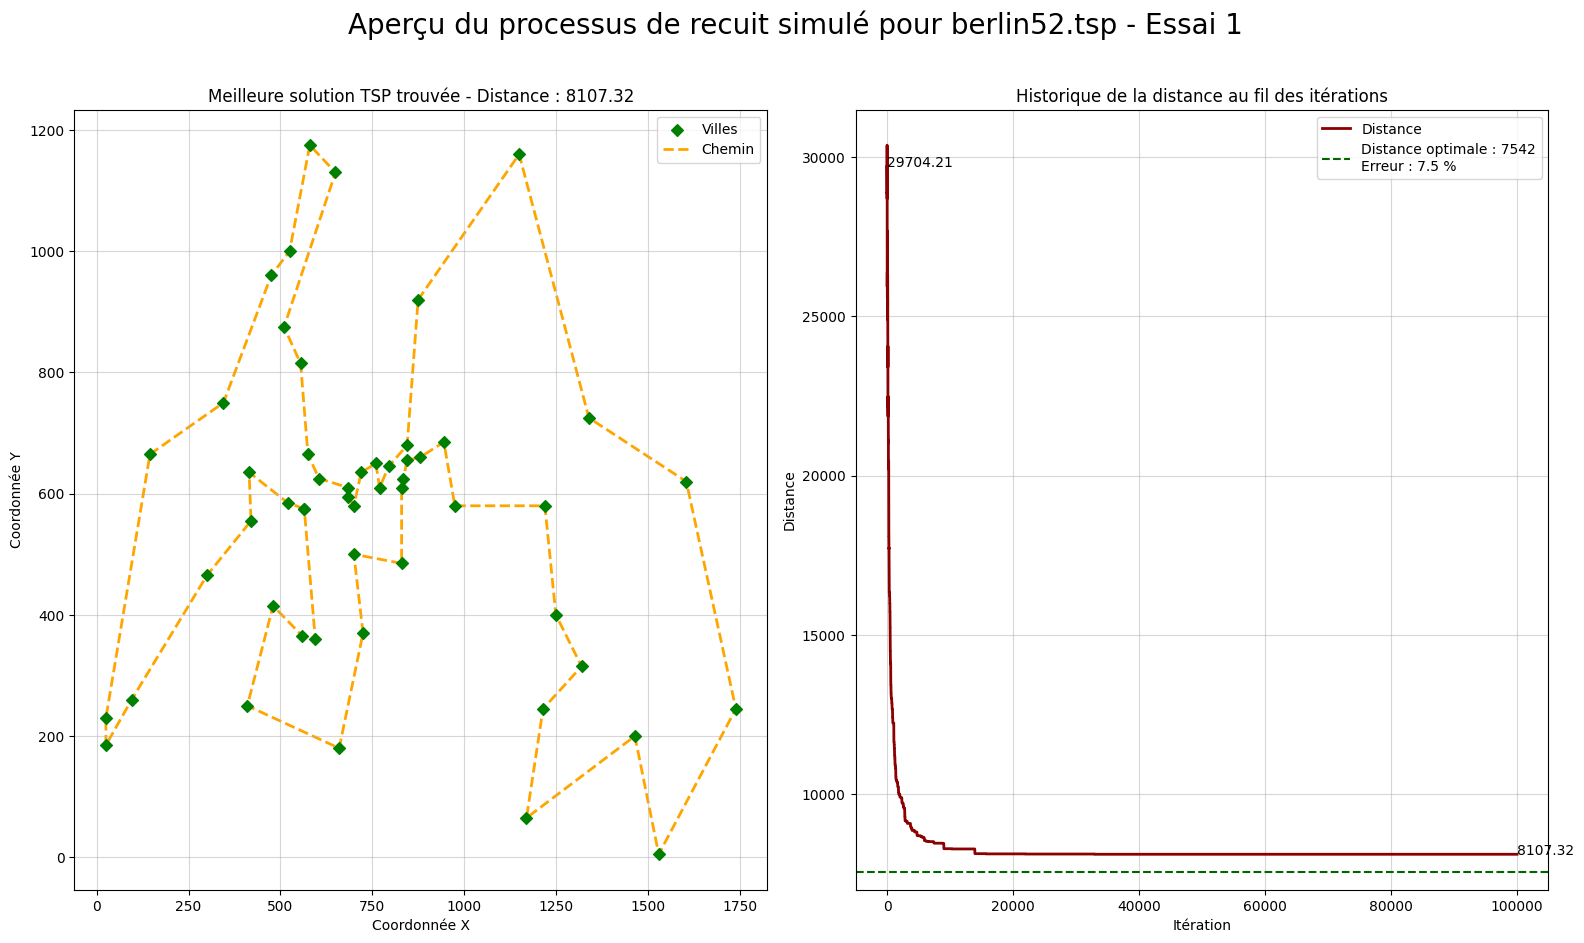

ESSAI 2 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (32, [575.0, 665.0])  (49, [605.0, 625.0])  (35, [685.0, 595.0])  (36, [685.0, 610.0])  
(39, [720.0, 635.0])  (40, [760.0, 650.0])  (38, [795.0, 645.0])  (15, [845.0, 680.0])  (6, [880.0, 660.0])  
(5, [845.0, 655.0])  (24, [835.0, 625.0])  (48, [830.0, 610.0])  (37, [770.0, 610.0])  (34, [700.0, 580.0])  
(44, [700.0, 500.0])  (46, [830.0, 485.0])  (28, [1250.0, 400.0])  (27, [1320.0, 315.0])  (26, [1215.0, 245.0])  
(47, [1170.0, 65.0])  (13, [1465.0, 200.0])  (14, [1530.0, 5.0])  (52, [1740.0, 245.0])  (11, [1605.0, 620.0])  
(51, [1340.0, 725.0])  (12, [1220.0, 580.0])  (25, [975.0, 580.0])  (4, [945.0, 685.0])  (43, [875.0, 920.0])  
(33, [1150.0, 1160.0])  (10, [650.0, 1130.0])  (9, [580.0, 1175.0])  (8, [525.0, 1000.0])  (41, [475.0, 960.0])

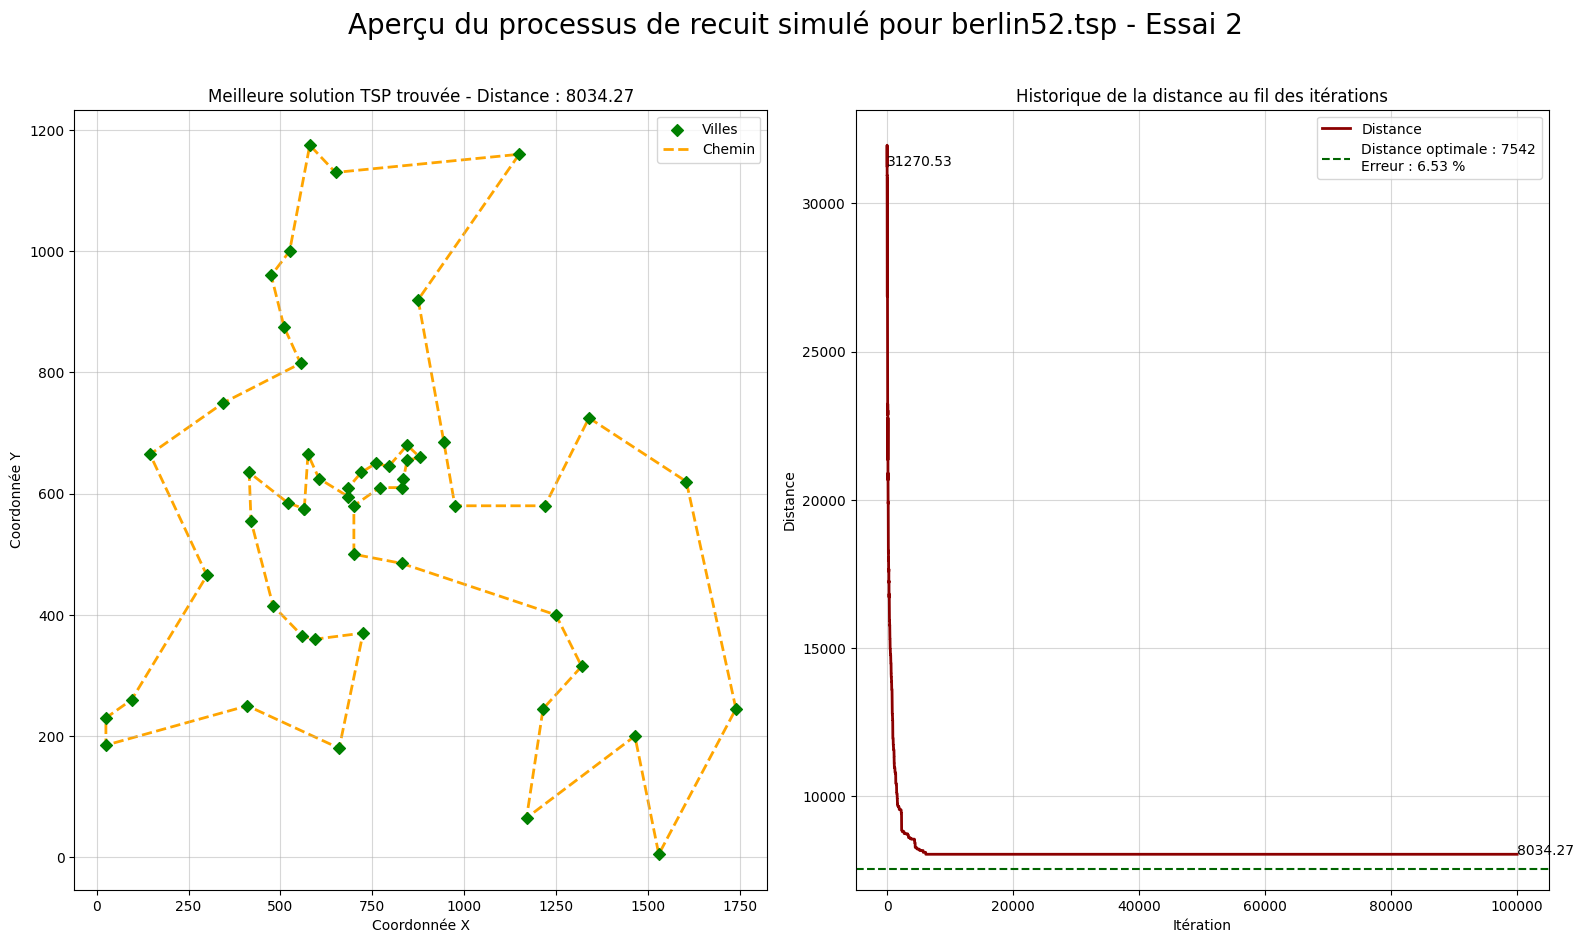

ESSAI 3 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (32, [575.0, 665.0])  (49, [605.0, 625.0])  (36, [685.0, 610.0])  (35, [685.0, 595.0])  
(34, [700.0, 580.0])  (44, [700.0, 500.0])  (50, [595.0, 360.0])  (20, [560.0, 365.0])  (29, [660.0, 180.0])  
(16, [725.0, 370.0])  (46, [830.0, 485.0])  (37, [770.0, 610.0])  (39, [720.0, 635.0])  (40, [760.0, 650.0])  
(38, [795.0, 645.0])  (48, [830.0, 610.0])  (24, [835.0, 625.0])  (5, [845.0, 655.0])  (15, [845.0, 680.0])  
(6, [880.0, 660.0])  (4, [945.0, 685.0])  (25, [975.0, 580.0])  (12, [1220.0, 580.0])  (28, [1250.0, 400.0])  
(27, [1320.0, 315.0])  (26, [1215.0, 245.0])  (47, [1170.0, 65.0])  (13, [1465.0, 200.0])  (14, [1530.0, 5.0])  
(52, [1740.0, 245.0])  (11, [1605.0, 620.0])  (51, [1340.0, 725.0])  (33, [1150.0, 1160.0])  (43, [875.0, 920.0]) 

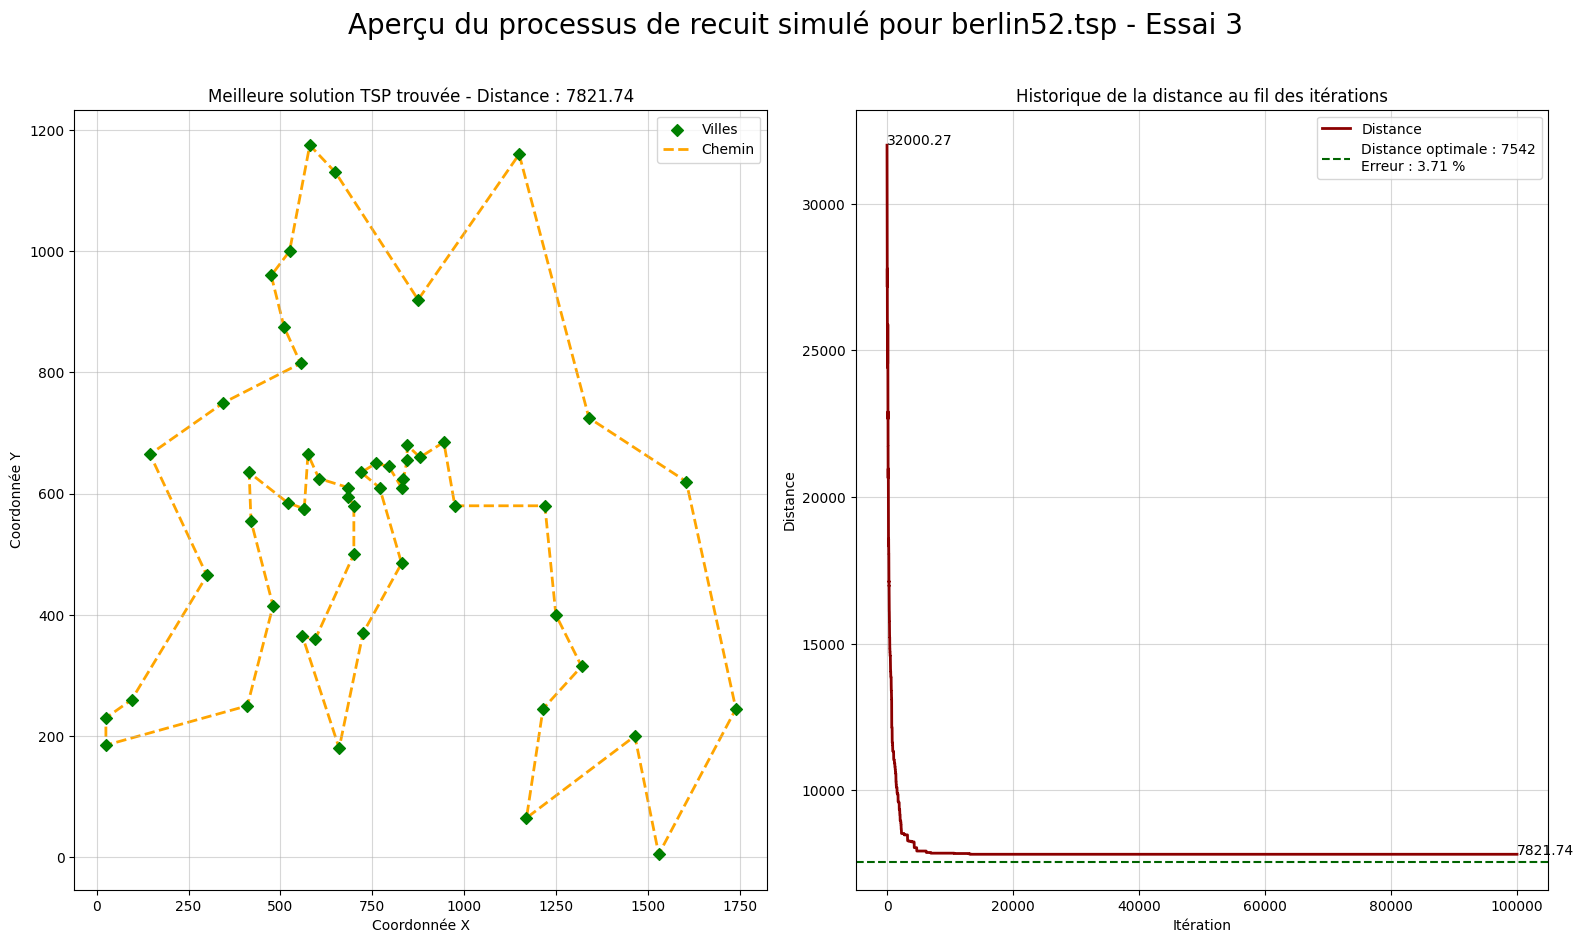

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Meilleure solution trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (32, [575.0, 665.0])  (49, [605.0, 625.0])  (36, [685.0, 610.0])  (35, [685.0, 595.0])  
(34, [700.0, 580.0])  (44, [700.0, 500.0])  (50, [595.0, 360.0])  (20, [560.0, 365.0])  (29, [660.0, 180.0])  
(16, [725.0, 370.0])  (46, [830.0, 485.0])  (37, [770.0, 610.0])  (39, [720.0, 635.0])  (40, [760.0, 650.0])  
(38, [795.0, 645.0])  (48, [830.0, 610.0])  (24, [835.0, 625.0])  (5, [845.0, 655.0])  (15, [845.0, 680.0])  
(6, [880.0, 660.0])  (4, [945.0, 685.0])  (25, [975.0, 580.0])  (12, [1220.0, 580.0])  (28, [1250.0, 400.0])  
(27, [1320.0, 315.0])  (26, [1215.0, 245.0])  (47, [1170.0, 65.0])  (13, [1465.0, 200.0])  (14, [1530.0, 5.0])  
(52, [1740.0, 245.0])  (11, [1605.0, 620.0])  (51, [1340.0, 725.0])  (33, [1150.0, 1160.0])  (43, [875.

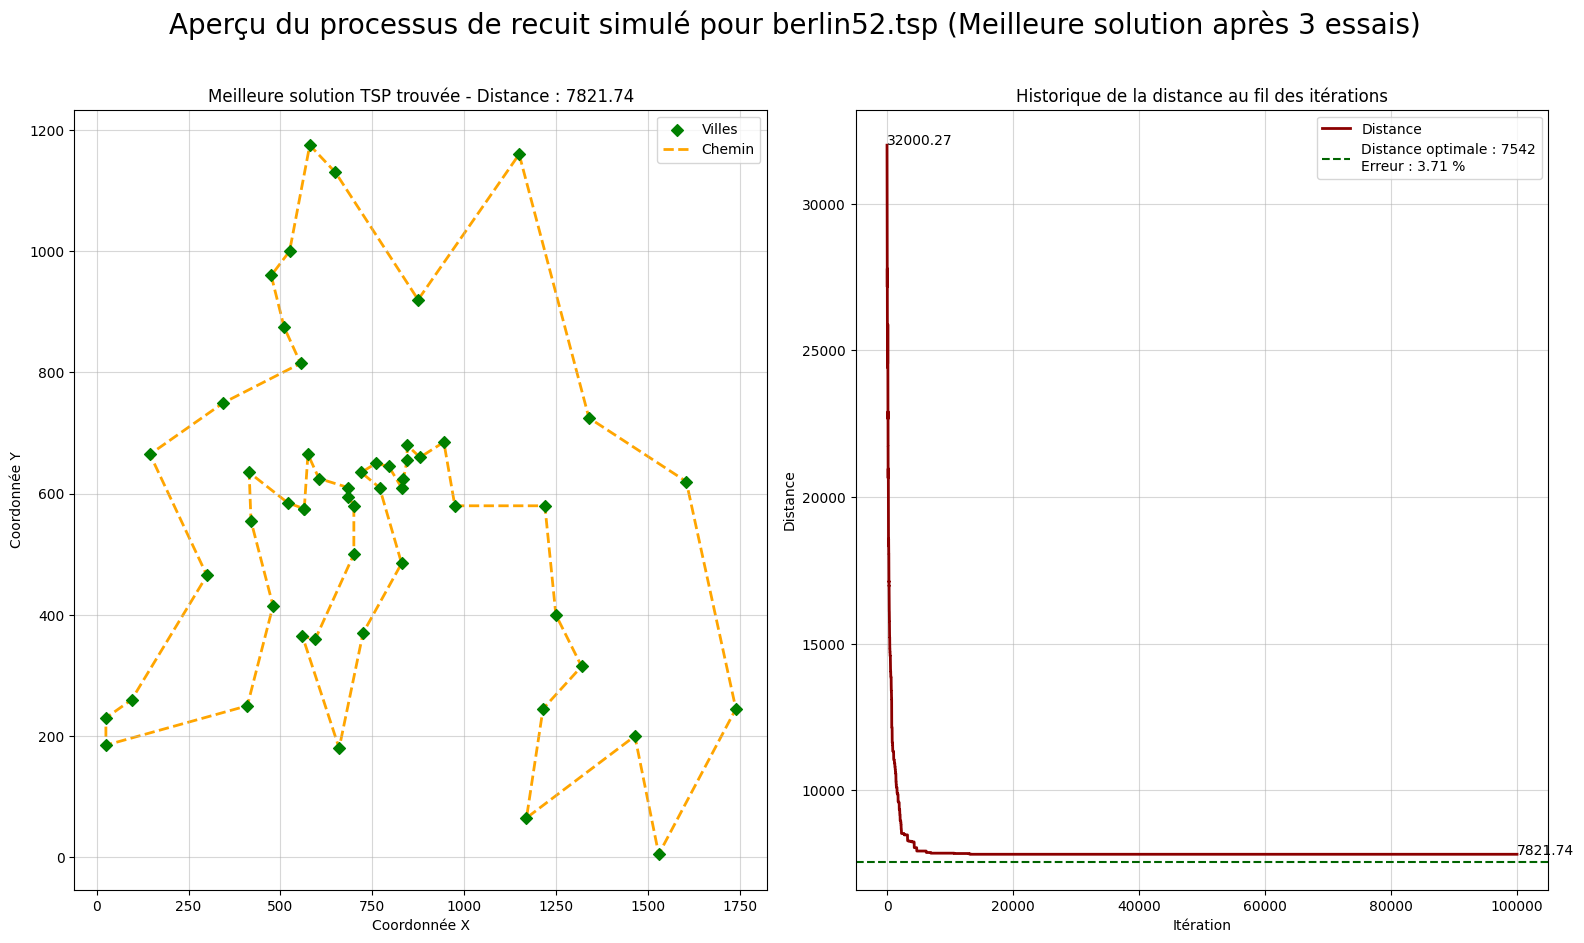

In [ ]:
# Paramètres pour l'exécution du solveur TSP
# temperature = 1000
# cooling_rate = 0.9
# iterations = 100000
# num_trials = 3

# Exécution du solveur TSP
tsp_solver(file_paths, temperature, cooling_rate, iterations, num_trials, optimal_distances)

In [34]:
# Liste de chemins de fichiers TSP
file_paths = ["/content/drive/MyDrive/Colab Notebooks/TSP_SA/berlin52.tsp",
              "/content/drive/MyDrive/Colab Notebooks/TSP_SA/pr107.tsp",
              "/content/drive/MyDrive/Colab Notebooks/TSP_SA/ulysses22.tsp"]

# Définir les distances optimales après la fonction tsp_solver
optimal_distances = {
    "/content/drive/MyDrive/Colab Notebooks/TSP_SA/berlin52.tsp": 7542,
    "/content/drive/MyDrive/Colab Notebooks/TSP_SA/pr107.tsp": 44303,
    "/content/drive/MyDrive/Colab Notebooks/TSP_SA/ulysses22.tsp": 70.13
}

Entrez la température initiale : 1000
Entrez le taux de refroidissement : 0.9
Entrez le nombre d'itérations : 10000
Entrez le nombre d'essais : 3

**************************************************FICHIER : berlin52.tsp**************************************************
ESSAI 1 ----------------------------------------------------------------------------------------------------------------------------------------------------------


<ipython-input-17-4e50a5b38c29>:12: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(-delta / temperature)


Solution optimale trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (49, [605.0, 625.0])  (32, [575.0, 665.0])  (45, [555.0, 815.0])  (19, [510.0, 875.0])  
(41, [475.0, 960.0])  (8, [525.0, 1000.0])  (9, [580.0, 1175.0])  (10, [650.0, 1130.0])  (43, [875.0, 920.0])  
(33, [1150.0, 1160.0])  (51, [1340.0, 725.0])  (11, [1605.0, 620.0])  (52, [1740.0, 245.0])  (14, [1530.0, 5.0])  
(13, [1465.0, 200.0])  (47, [1170.0, 65.0])  (26, [1215.0, 245.0])  (27, [1320.0, 315.0])  (28, [1250.0, 400.0])  
(12, [1220.0, 580.0])  (25, [975.0, 580.0])  (4, [945.0, 685.0])  (6, [880.0, 660.0])  (15, [845.0, 680.0])  
(5, [845.0, 655.0])  (24, [835.0, 625.0])  (48, [830.0, 610.0])  (46, [830.0, 485.0])  (37, [770.0, 610.0])  
(38, [795.0, 645.0])  (40, [760.0, 650.0])  (39, [720.0, 635.0])  (36, [685.0, 610.0])  (35, [685.0, 595.0])  
(34, [700.0, 580.0])  (44, [700.0, 500.0])  (16, [725.0, 370.0])  (29, [660.0, 180.0])  (50, [595.0, 360.0])  
(20, [560.0, 365.0])  (23, [480.0, 415.0])  (30, 

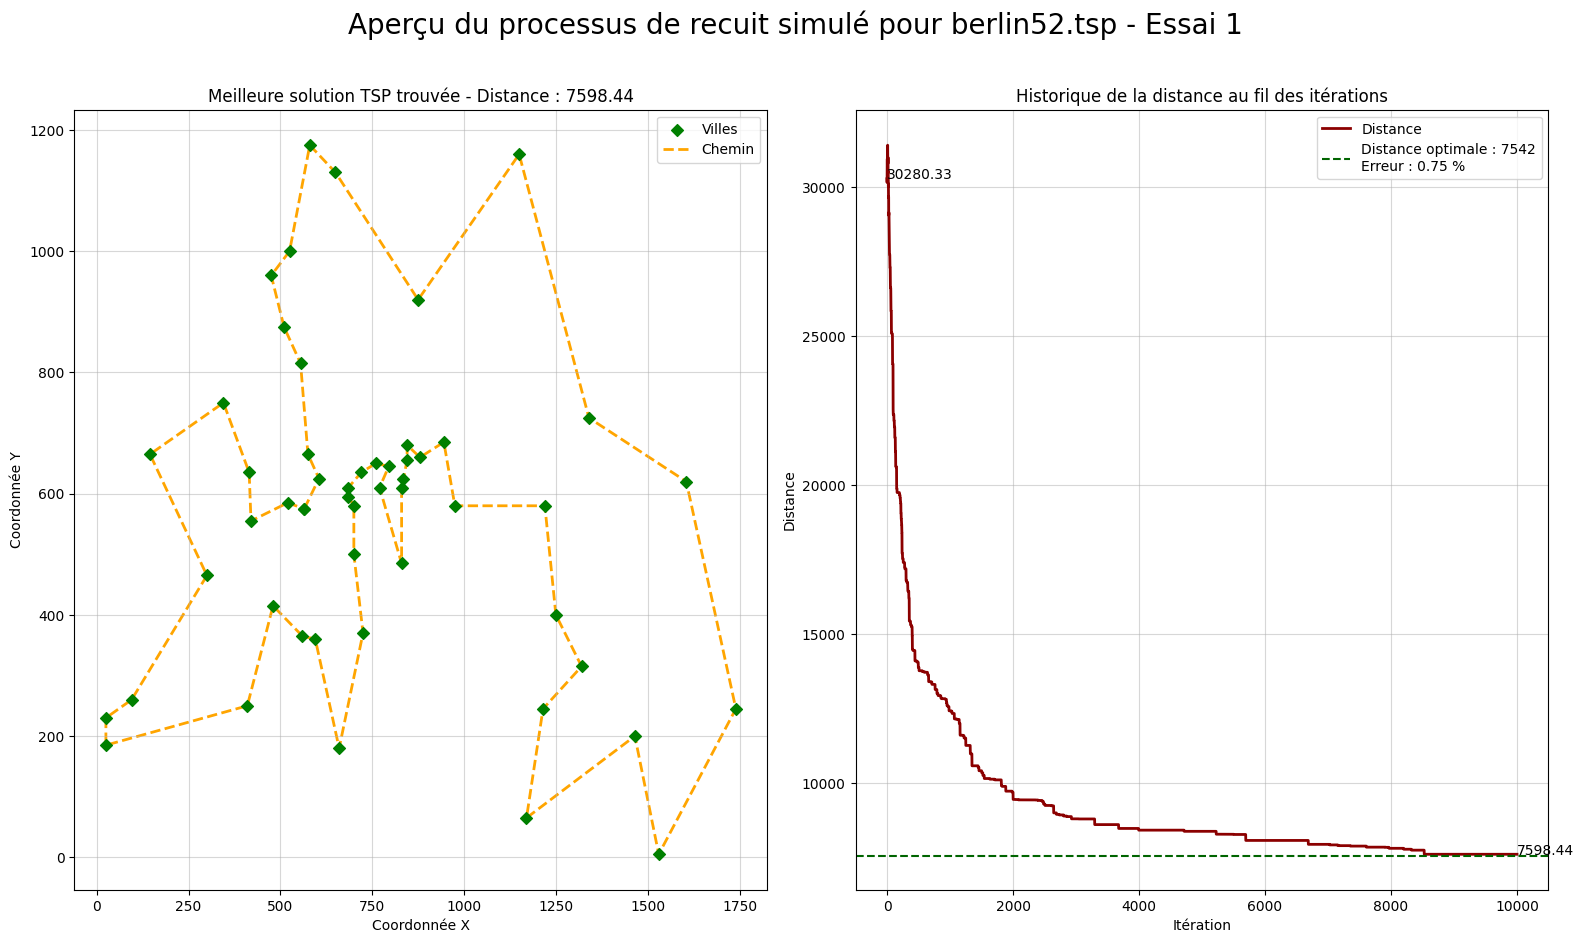

ESSAI 2 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (49, [605.0, 625.0])  (32, [575.0, 665.0])  (45, [555.0, 815.0])  (19, [510.0, 875.0])  
(41, [475.0, 960.0])  (8, [525.0, 1000.0])  (9, [580.0, 1175.0])  (10, [650.0, 1130.0])  (43, [875.0, 920.0])  
(33, [1150.0, 1160.0])  (51, [1340.0, 725.0])  (11, [1605.0, 620.0])  (52, [1740.0, 245.0])  (14, [1530.0, 5.0])  
(13, [1465.0, 200.0])  (27, [1320.0, 315.0])  (47, [1170.0, 65.0])  (26, [1215.0, 245.0])  (28, [1250.0, 400.0])  
(12, [1220.0, 580.0])  (25, [975.0, 580.0])  (4, [945.0, 685.0])  (6, [880.0, 660.0])  (15, [845.0, 680.0])  
(5, [845.0, 655.0])  (48, [830.0, 610.0])  (24, [835.0, 625.0])  (38, [795.0, 645.0])  (37, [770.0, 610.0])  
(40, [760.0, 650.0])  (39, [720.0, 635.0])  (36, [685.0, 610.0])  (35, [685.0, 595.0])  (34, [700.0, 580.0])

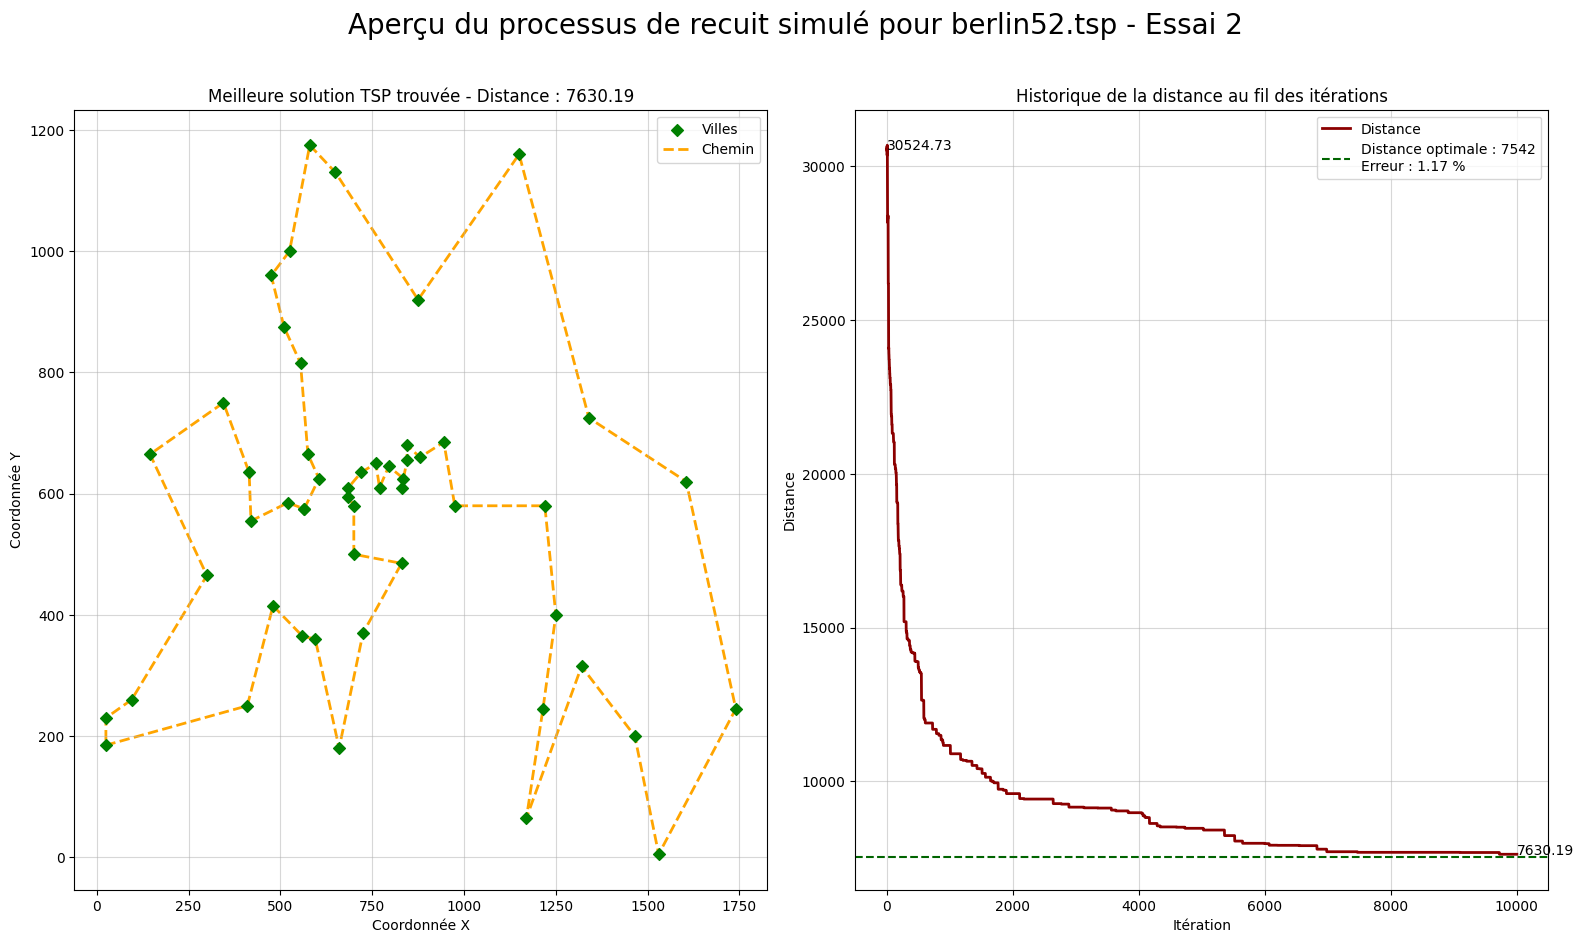

ESSAI 3 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (49, [605.0, 625.0])  (32, [575.0, 665.0])  (45, [555.0, 815.0])  (19, [510.0, 875.0])  
(41, [475.0, 960.0])  (8, [525.0, 1000.0])  (9, [580.0, 1175.0])  (10, [650.0, 1130.0])  (43, [875.0, 920.0])  
(33, [1150.0, 1160.0])  (51, [1340.0, 725.0])  (12, [1220.0, 580.0])  (11, [1605.0, 620.0])  (52, [1740.0, 245.0])  
(14, [1530.0, 5.0])  (13, [1465.0, 200.0])  (47, [1170.0, 65.0])  (26, [1215.0, 245.0])  (27, [1320.0, 315.0])  
(28, [1250.0, 400.0])  (25, [975.0, 580.0])  (4, [945.0, 685.0])  (6, [880.0, 660.0])  (15, [845.0, 680.0])  
(5, [845.0, 655.0])  (24, [835.0, 625.0])  (48, [830.0, 610.0])  (46, [830.0, 485.0])  (37, [770.0, 610.0])  
(38, [795.0, 645.0])  (40, [760.0, 650.0])  (39, [720.0, 635.0])  (36, [685.0, 610.0])  (35, [685.0, 595.0])

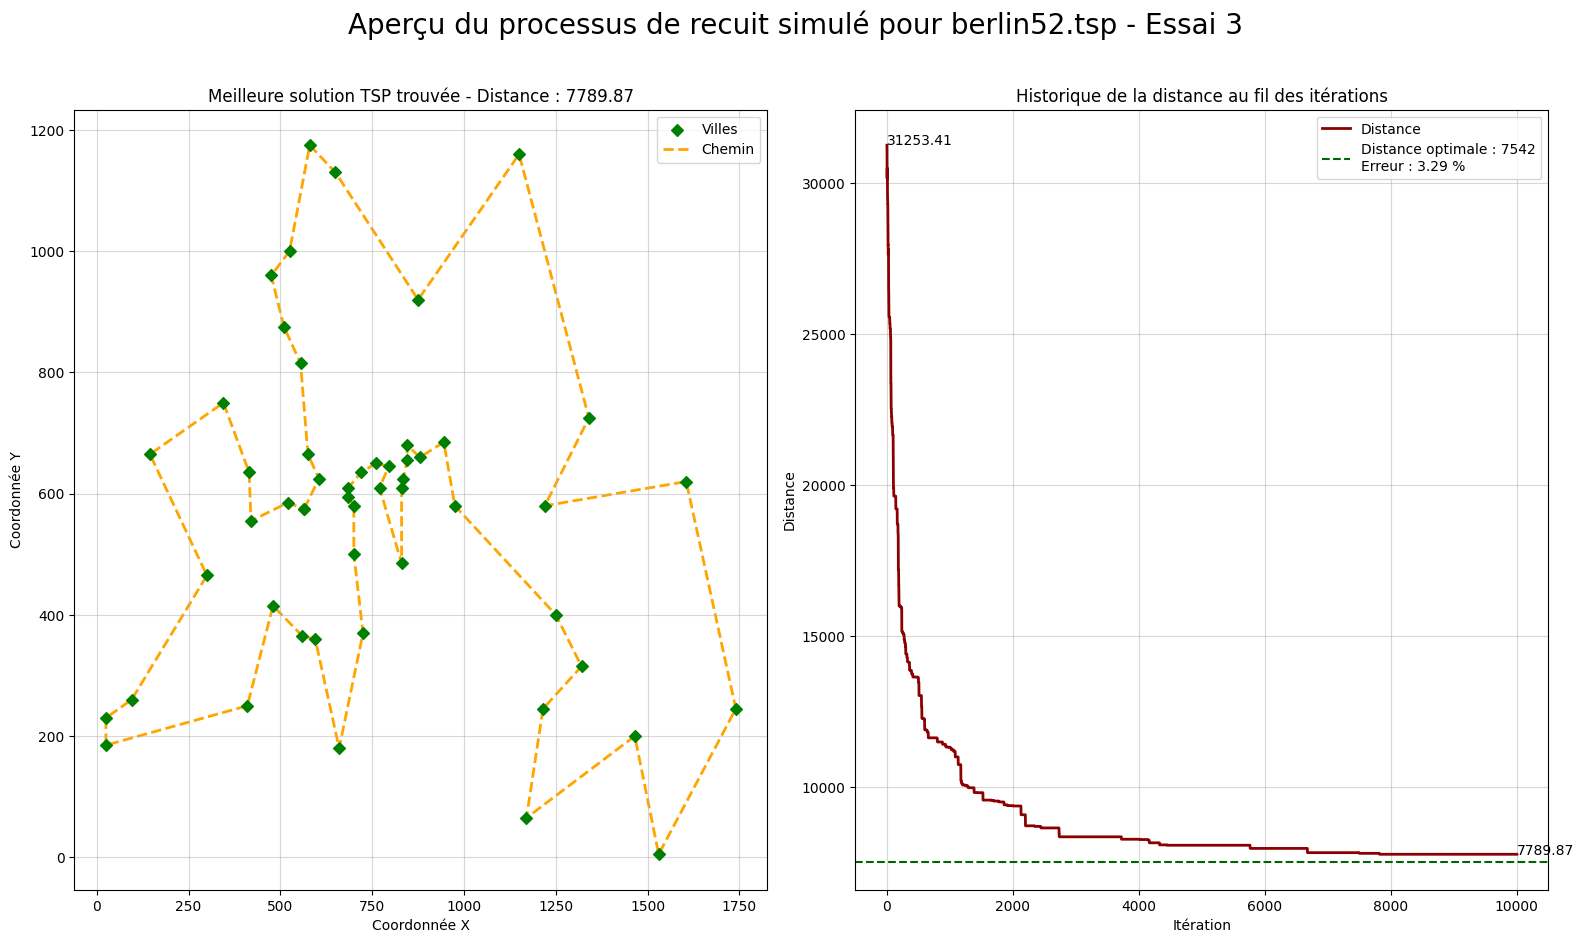

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Meilleure solution trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (49, [605.0, 625.0])  (32, [575.0, 665.0])  (45, [555.0, 815.0])  (19, [510.0, 875.0])  
(41, [475.0, 960.0])  (8, [525.0, 1000.0])  (9, [580.0, 1175.0])  (10, [650.0, 1130.0])  (43, [875.0, 920.0])  
(33, [1150.0, 1160.0])  (51, [1340.0, 725.0])  (11, [1605.0, 620.0])  (52, [1740.0, 245.0])  (14, [1530.0, 5.0])  
(13, [1465.0, 200.0])  (47, [1170.0, 65.0])  (26, [1215.0, 245.0])  (27, [1320.0, 315.0])  (28, [1250.0, 400.0])  
(12, [1220.0, 580.0])  (25, [975.0, 580.0])  (4, [945.0, 685.0])  (6, [880.0, 660.0])  (15, [845.0, 680.0])  
(5, [845.0, 655.0])  (24, [835.0, 625.0])  (48, [830.0, 610.0])  (46, [830.0, 485.0])  (37, [770.0, 610.0])  
(38, [795.0, 645.0])  (40, [760.0, 650.0])  (39, [720.0, 635.0])  (36, [685.0, 610.0])  (35, [685

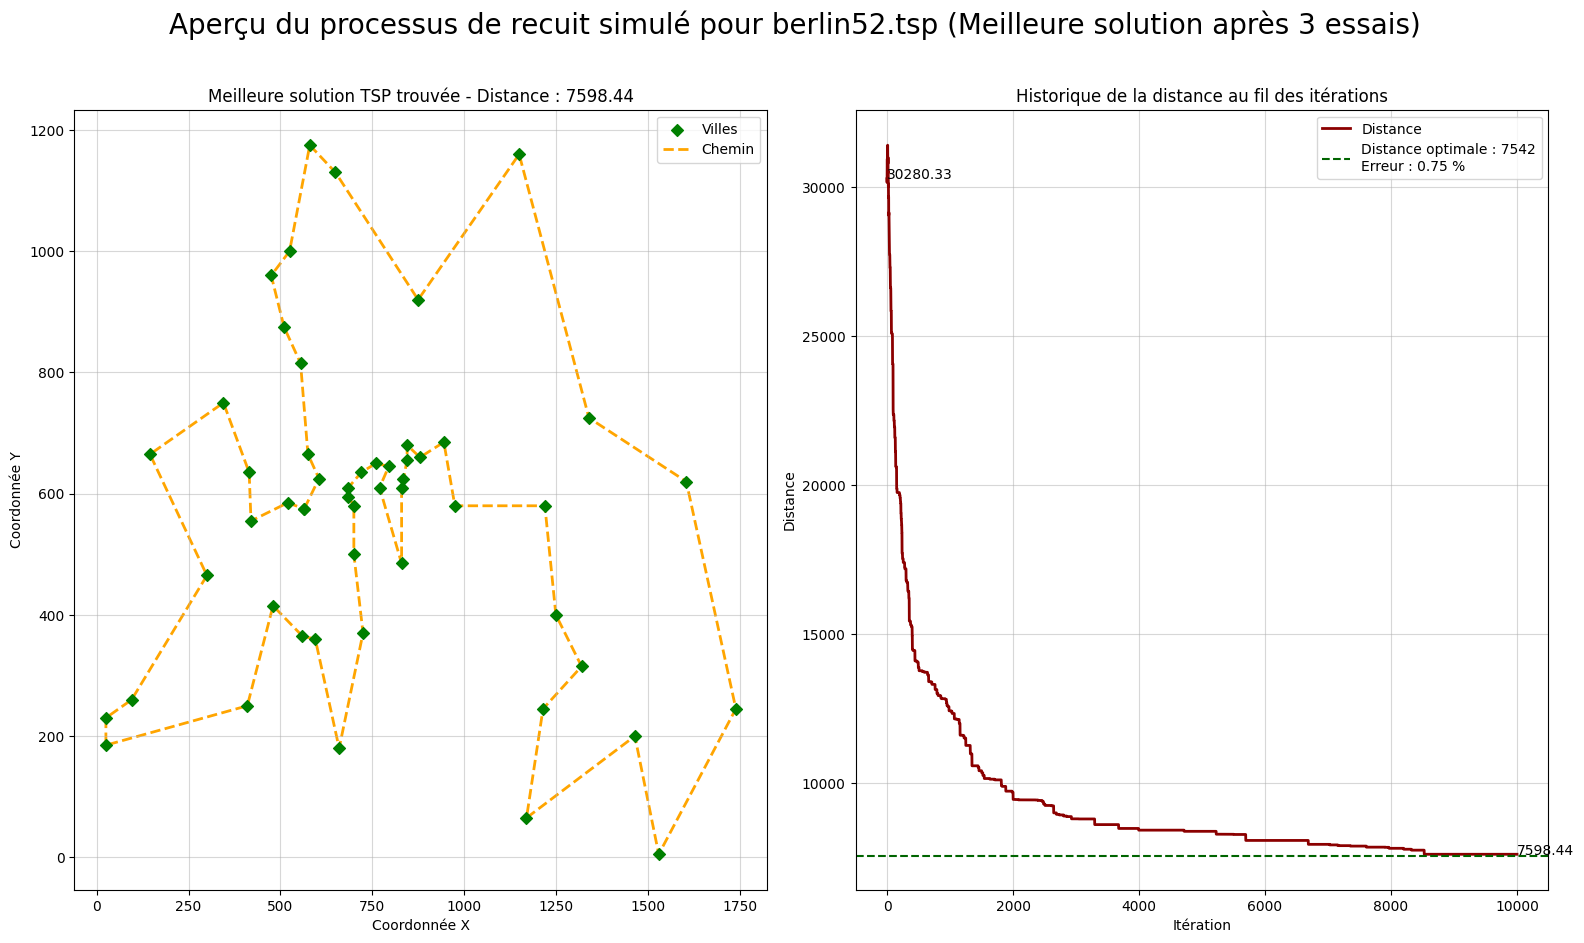


**************************************************FICHIER : pr107.tsp**************************************************
ESSAI 1 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier pr107.tsp :
(1, [8375.0, 4700.0])  (3, [8375.0, 4900.0])  (11, [8375.0, 5650.0])  (13, [8375.0, 6200.0])  (16, [8175.0, 6400.0])  
(15, [8375.0, 6400.0])  (18, [8575.0, 6400.0])  (9, [8775.0, 5600.0])  (62, [15825.0, 5650.0])  (74, [16025.0, 6200.0])  
(77, [16225.0, 6400.0])  (78, [16425.0, 6400.0])  (82, [16225.0, 7200.0])  (80, [16425.0, 7000.0])  (71, [16225.0, 5600.0])  
(73, [16025.0, 5650.0])  (70, [16025.0, 5450.0])  (68, [16425.0, 4900.0])  (65, [16425.0, 4700.0])  (67, [16225.0, 4900.0])  
(64, [16025.0, 4700.0])  (66, [16025.0, 4900.0])  (63, [15825.0, 4900.0])  (69, [16425.0, 5400.0])  (72, [16425.0, 5600.0])  
(75, [16425.0, 6200.0])  (76, [16025.0, 640

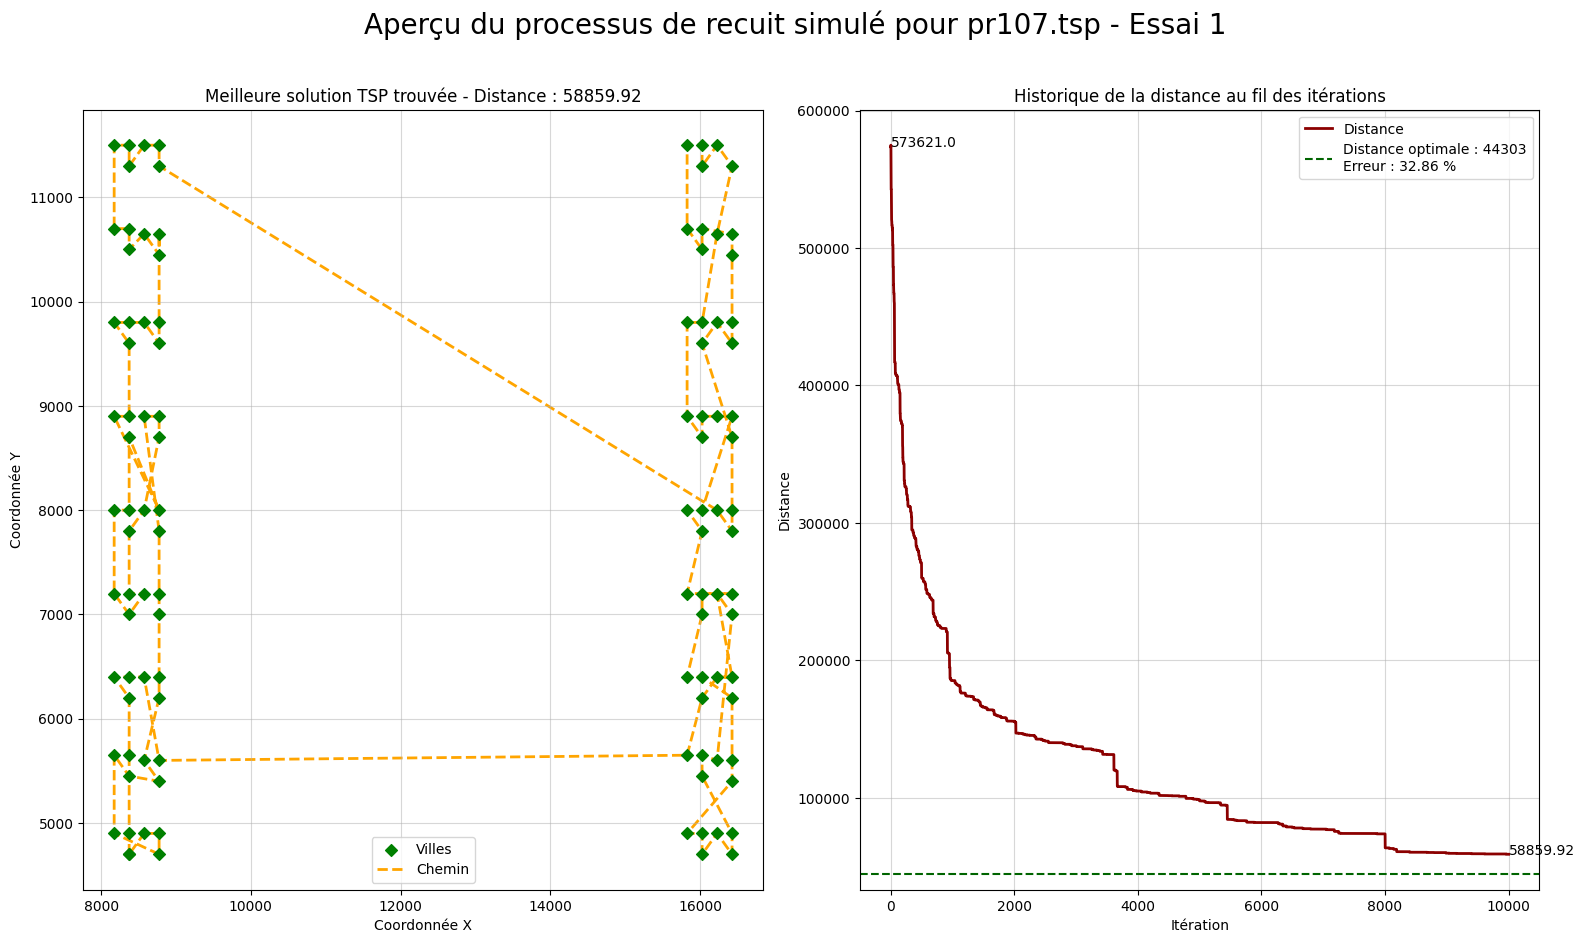

ESSAI 2 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier pr107.tsp :
(1, [8375.0, 4700.0])  (5, [8775.0, 4900.0])  (15, [8375.0, 6400.0])  (16, [8175.0, 6400.0])  (19, [8375.0, 7000.0])  
(30, [8575.0, 8000.0])  (26, [8775.0, 7800.0])  (29, [8775.0, 8000.0])  (32, [8775.0, 8700.0])  (35, [8775.0, 8900.0])  
(36, [8575.0, 8900.0])  (38, [8775.0, 9600.0])  (41, [8775.0, 9800.0])  (39, [8375.0, 9800.0])  (40, [8175.0, 9800.0])  
(37, [8375.0, 9600.0])  (42, [8575.0, 9800.0])  (44, [8775.0, 10450.0])  (47, [8775.0, 10650.0])  (48, [8575.0, 10650.0])  
(43, [8375.0, 10500.0])  (46, [8175.0, 10700.0])  (45, [8375.0, 10700.0])  (49, [8375.0, 11300.0])  (52, [8175.0, 11500.0])  
(51, [8375.0, 11500.0])  (54, [8575.0, 11500.0])  (50, [8775.0, 11300.0])  (53, [8775.0, 11500.0])  (55, [15825.0, 11500.0])  
(106, [16025.0, 11500.0])  (107, [16225.0, 11

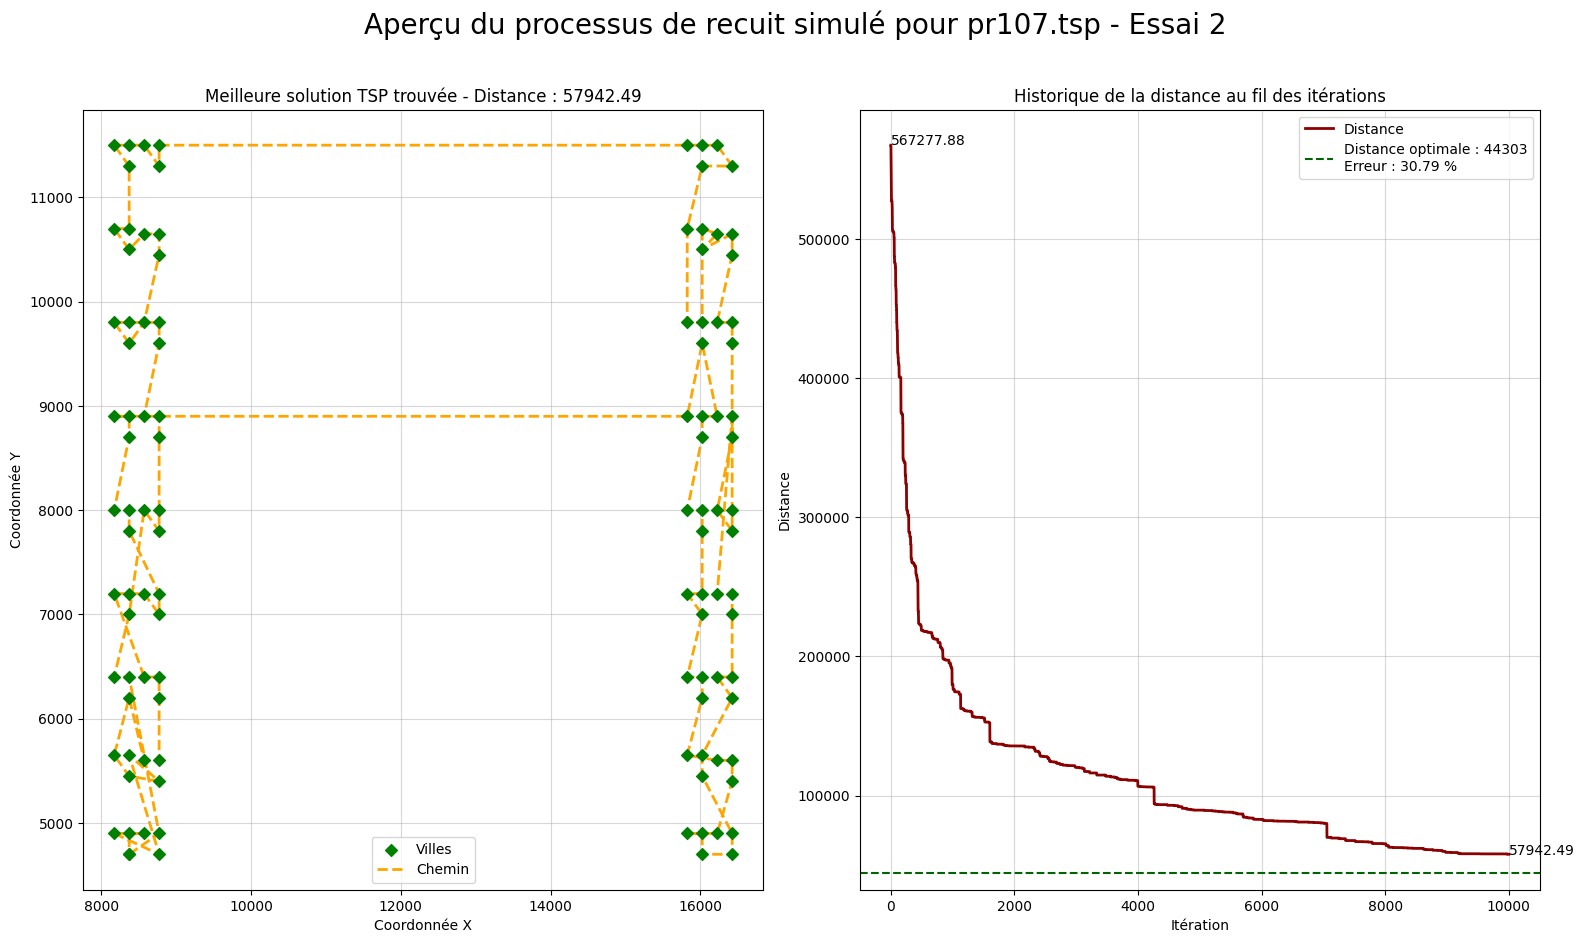

ESSAI 3 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier pr107.tsp :
(1, [8375.0, 4700.0])  (3, [8375.0, 4900.0])  (6, [8575.0, 4900.0])  (2, [8775.0, 4700.0])  (5, [8775.0, 4900.0])  
(7, [8775.0, 5400.0])  (9, [8775.0, 5600.0])  (13, [8375.0, 6200.0])  (15, [8375.0, 6400.0])  (16, [8175.0, 6400.0])  
(22, [8175.0, 7200.0])  (28, [8175.0, 8000.0])  (32, [8775.0, 8700.0])  (56, [15825.0, 10700.0])  (104, [16025.0, 11300.0])  
(106, [16025.0, 11500.0])  (55, [15825.0, 11500.0])  (107, [16225.0, 11500.0])  (105, [16425.0, 11300.0])  (102, [16225.0, 10650.0])  
(101, [16025.0, 10700.0])  (99, [16025.0, 10500.0])  (103, [16425.0, 10650.0])  (100, [16425.0, 10450.0])  (98, [16425.0, 9800.0])  
(95, [16425.0, 9600.0])  (97, [16225.0, 9800.0])  (96, [16025.0, 9800.0])  (57, [15825.0, 9800.0])  (94, [16025.0, 9600.0])  
(90, [16425.0, 8700.0])  (87

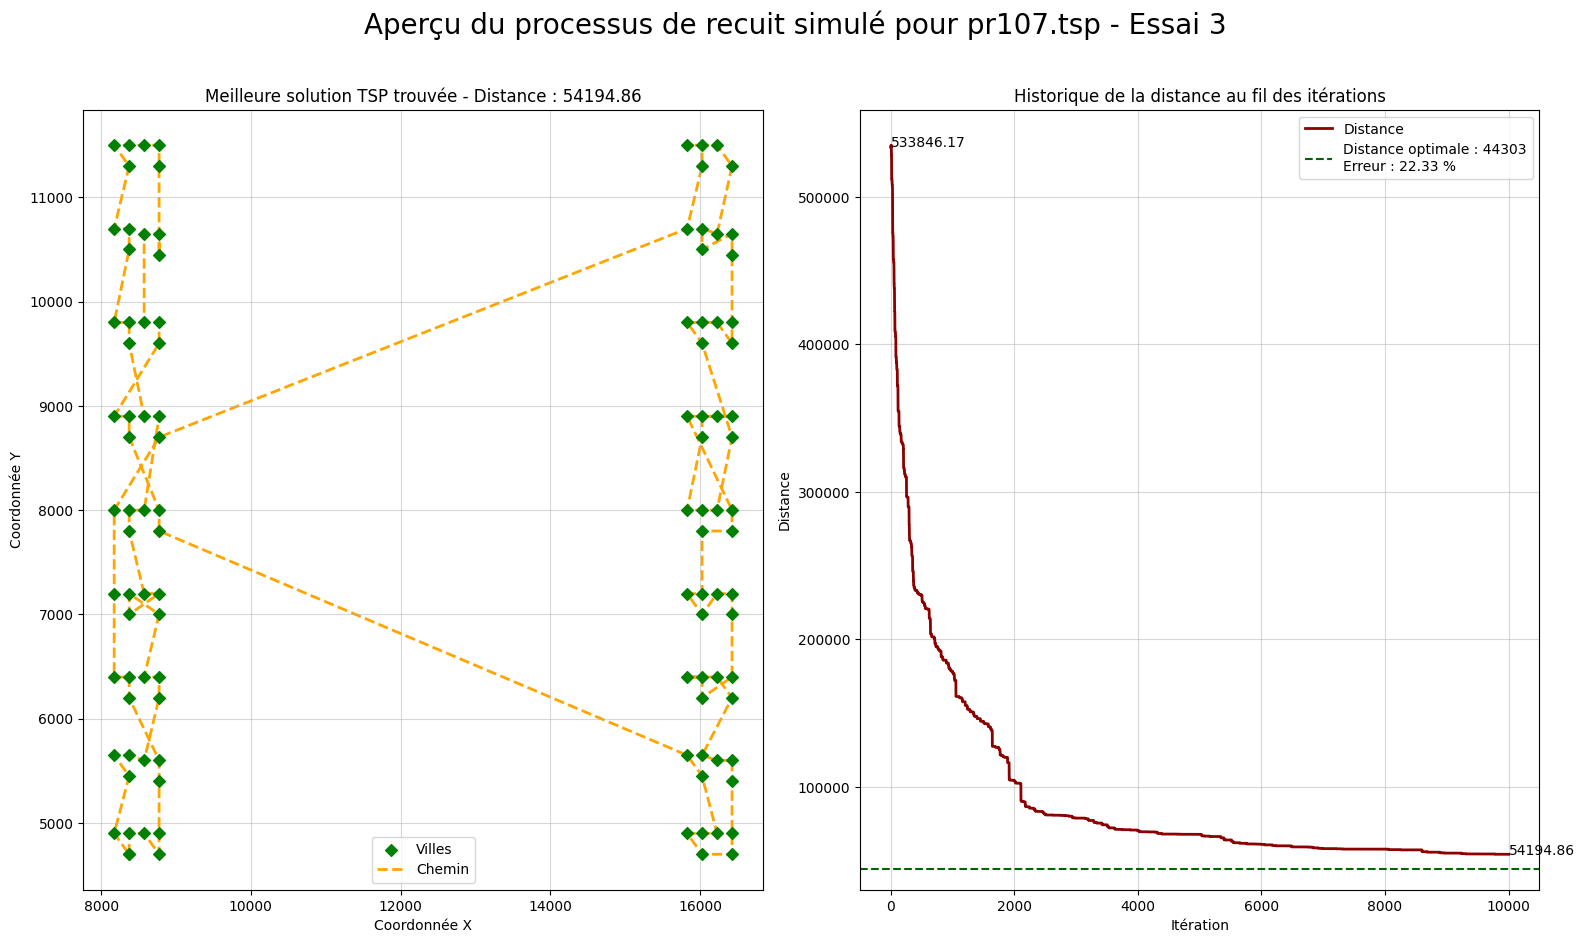

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Meilleure solution trouvée pour le fichier pr107.tsp :
(1, [8375.0, 4700.0])  (3, [8375.0, 4900.0])  (6, [8575.0, 4900.0])  (2, [8775.0, 4700.0])  (5, [8775.0, 4900.0])  
(7, [8775.0, 5400.0])  (9, [8775.0, 5600.0])  (13, [8375.0, 6200.0])  (15, [8375.0, 6400.0])  (16, [8175.0, 6400.0])  
(22, [8175.0, 7200.0])  (28, [8175.0, 8000.0])  (32, [8775.0, 8700.0])  (56, [15825.0, 10700.0])  (104, [16025.0, 11300.0])  
(106, [16025.0, 11500.0])  (55, [15825.0, 11500.0])  (107, [16225.0, 11500.0])  (105, [16425.0, 11300.0])  (102, [16225.0, 10650.0])  
(101, [16025.0, 10700.0])  (99, [16025.0, 10500.0])  (103, [16425.0, 10650.0])  (100, [16425.0, 10450.0])  (98, [16425.0, 9800.0])  
(95, [16425.0, 9600.0])  (97, [16225.0, 9800.0])  (96, [16025.0, 9800.0])  (57, [15825.0, 9800.0])  (94, [16025.0, 9600.0])  
(90, [16425.0, 87

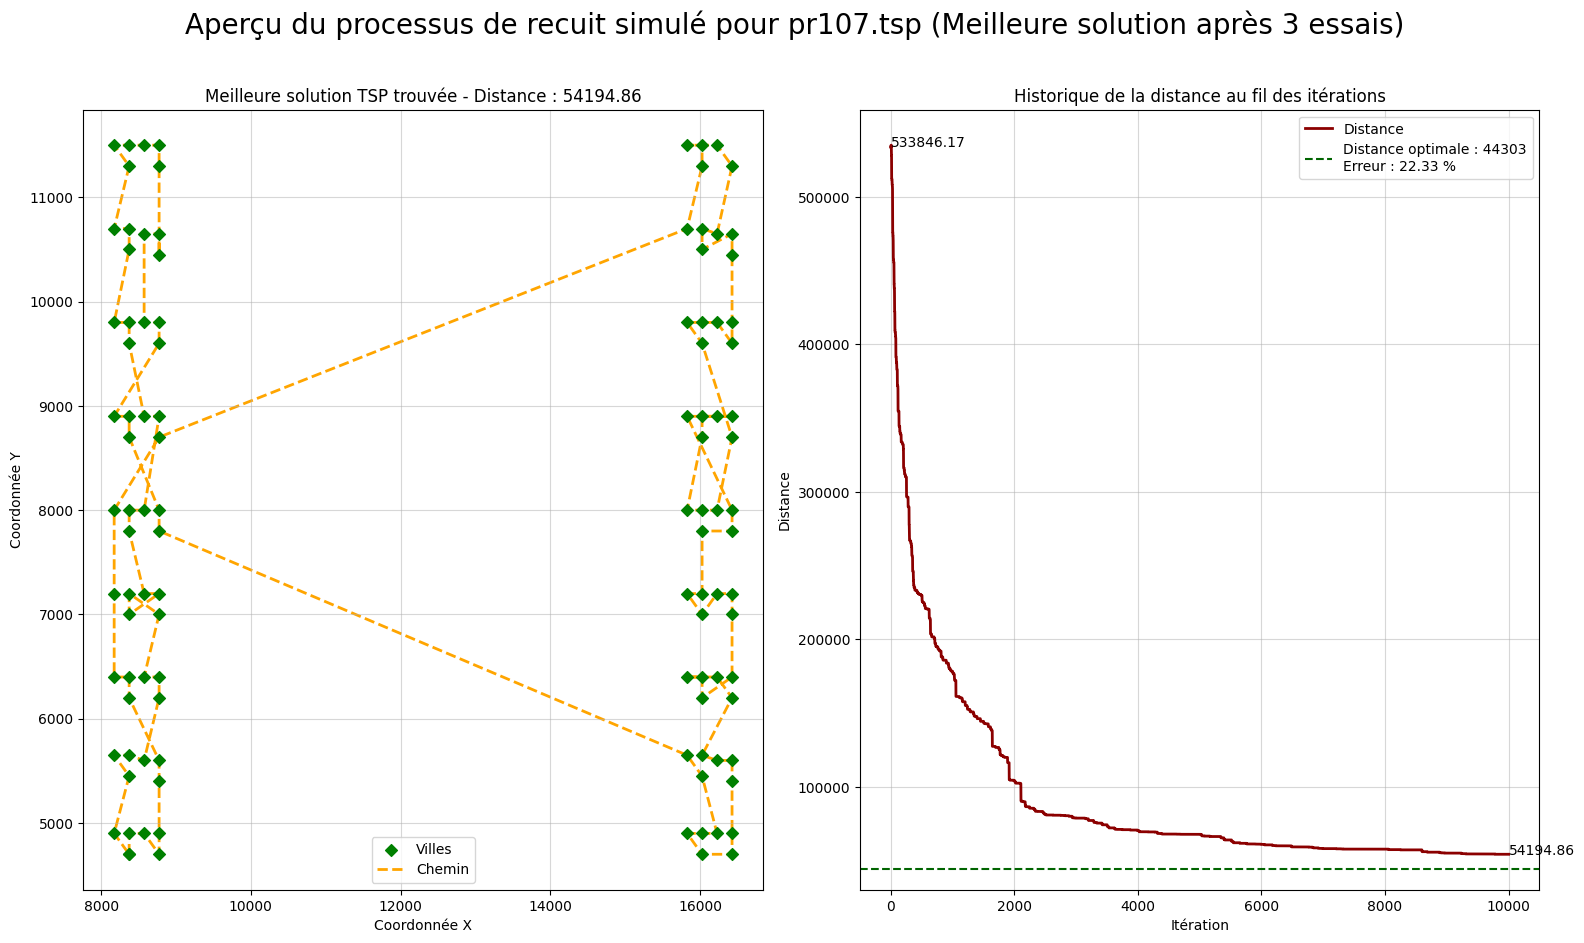


**************************************************FICHIER : ulysses22.tsp**************************************************
ESSAI 1 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier ulysses22.tsp :
(1, [38.24, 20.42])  (3, [40.56, 25.32])  (2, [39.57, 26.15])  (17, [38.09, 24.36])  (4, [36.26, 23.12])  
(18, [36.09, 23.0])  (22, [37.57, 22.56])  (8, [37.52, 20.44])  (15, [35.49, 14.32])  (5, [33.48, 10.54])  
(11, [36.08, -5.21])  (9, [41.23, 9.1])  (10, [41.17, 13.05])  (19, [40.44, 13.57])  (21, [40.37, 14.23])  
(20, [40.33, 14.15])  (7, [38.42, 13.11])  (6, [37.56, 12.19])  (14, [37.51, 15.17])  (13, [38.15, 15.35])  
(12, [38.47, 15.13])  (16, [39.36, 19.56])  (1, [38.24, 20.42])  
Longueur du parcours optimal : 76.01816597362199
Temps d'exécution : 1.8118696212768555 s


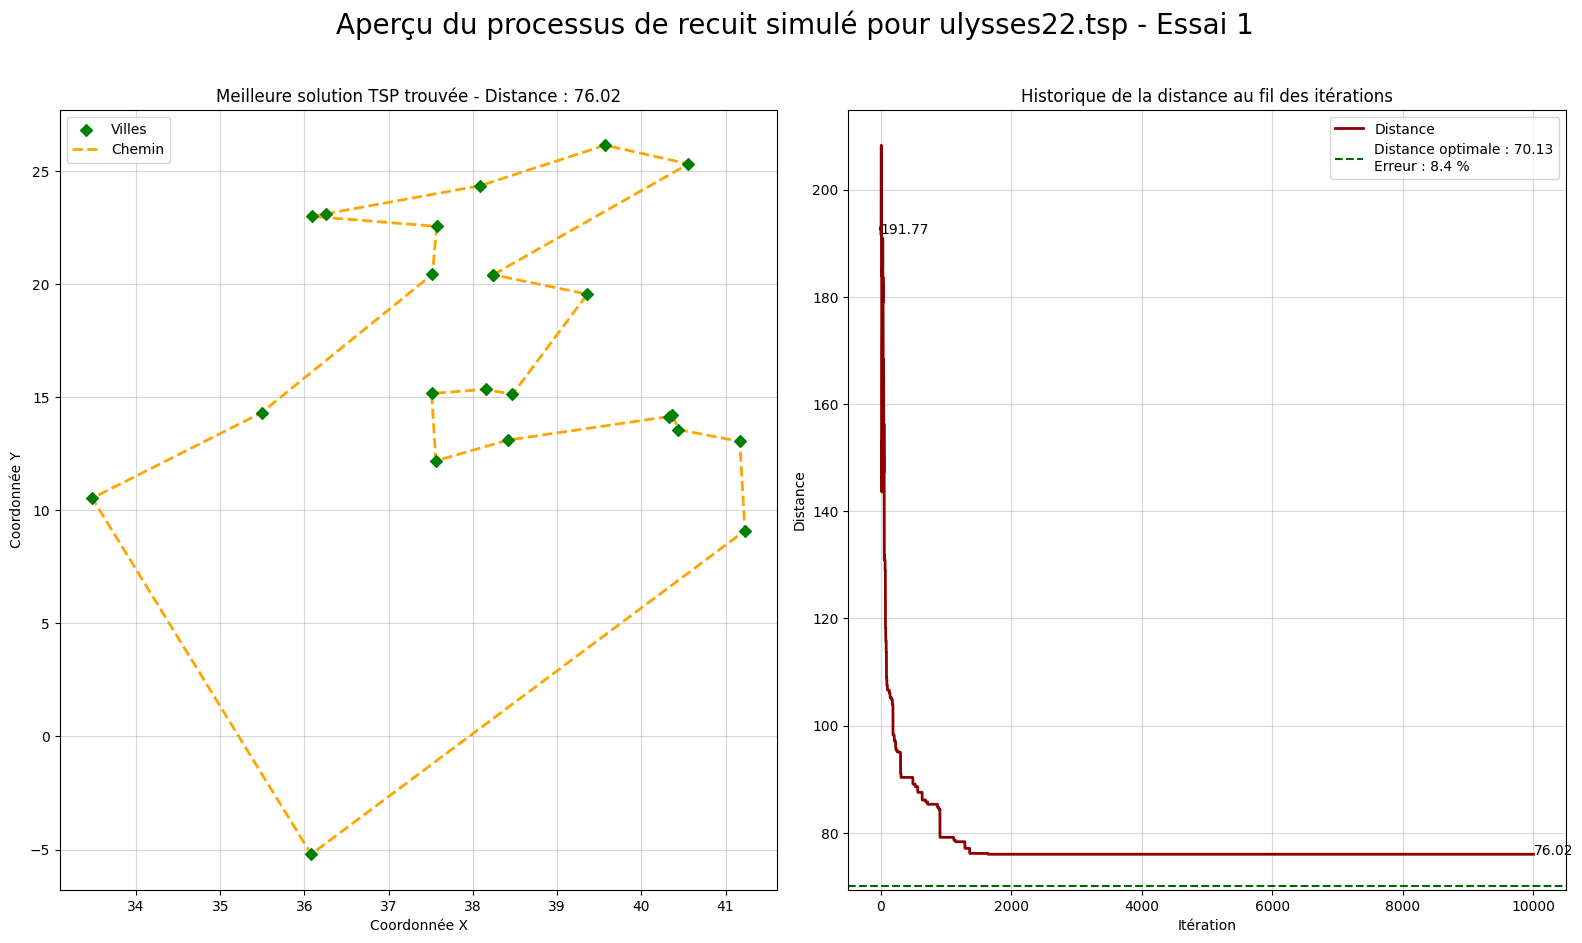

ESSAI 2 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier ulysses22.tsp :
(1, [38.24, 20.42])  (3, [40.56, 25.32])  (2, [39.57, 26.15])  (17, [38.09, 24.36])  (4, [36.26, 23.12])  
(18, [36.09, 23.0])  (22, [37.57, 22.56])  (8, [37.52, 20.44])  (14, [37.51, 15.17])  (7, [38.42, 13.11])  
(6, [37.56, 12.19])  (15, [35.49, 14.32])  (5, [33.48, 10.54])  (11, [36.08, -5.21])  (9, [41.23, 9.1])  
(10, [41.17, 13.05])  (19, [40.44, 13.57])  (20, [40.33, 14.15])  (21, [40.37, 14.23])  (12, [38.47, 15.13])  
(13, [38.15, 15.35])  (16, [39.36, 19.56])  (1, [38.24, 20.42])  
Longueur du parcours optimal : 76.13337483800908
Temps d'exécution : 2.484940528869629 s


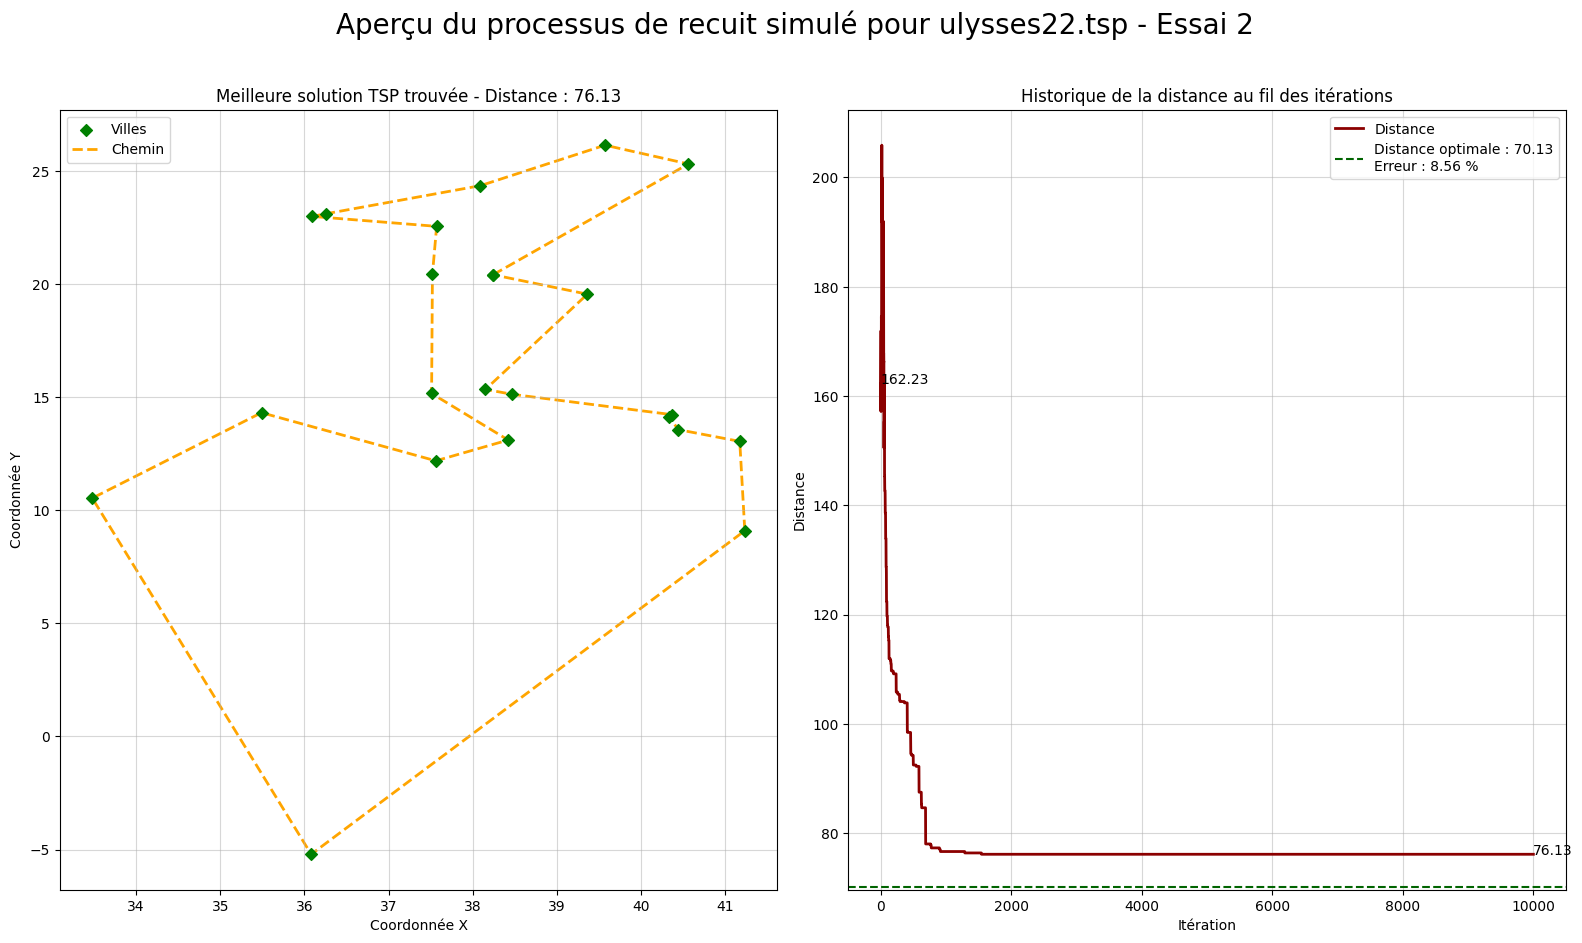

ESSAI 3 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier ulysses22.tsp :
(1, [38.24, 20.42])  (3, [40.56, 25.32])  (2, [39.57, 26.15])  (17, [38.09, 24.36])  (4, [36.26, 23.12])  
(18, [36.09, 23.0])  (22, [37.57, 22.56])  (8, [37.52, 20.44])  (14, [37.51, 15.17])  (7, [38.42, 13.11])  
(6, [37.56, 12.19])  (15, [35.49, 14.32])  (5, [33.48, 10.54])  (11, [36.08, -5.21])  (9, [41.23, 9.1])  
(10, [41.17, 13.05])  (19, [40.44, 13.57])  (20, [40.33, 14.15])  (21, [40.37, 14.23])  (12, [38.47, 15.13])  
(13, [38.15, 15.35])  (16, [39.36, 19.56])  (1, [38.24, 20.42])  
Longueur du parcours optimal : 76.13337483800908
Temps d'exécution : 1.9415051937103271 s


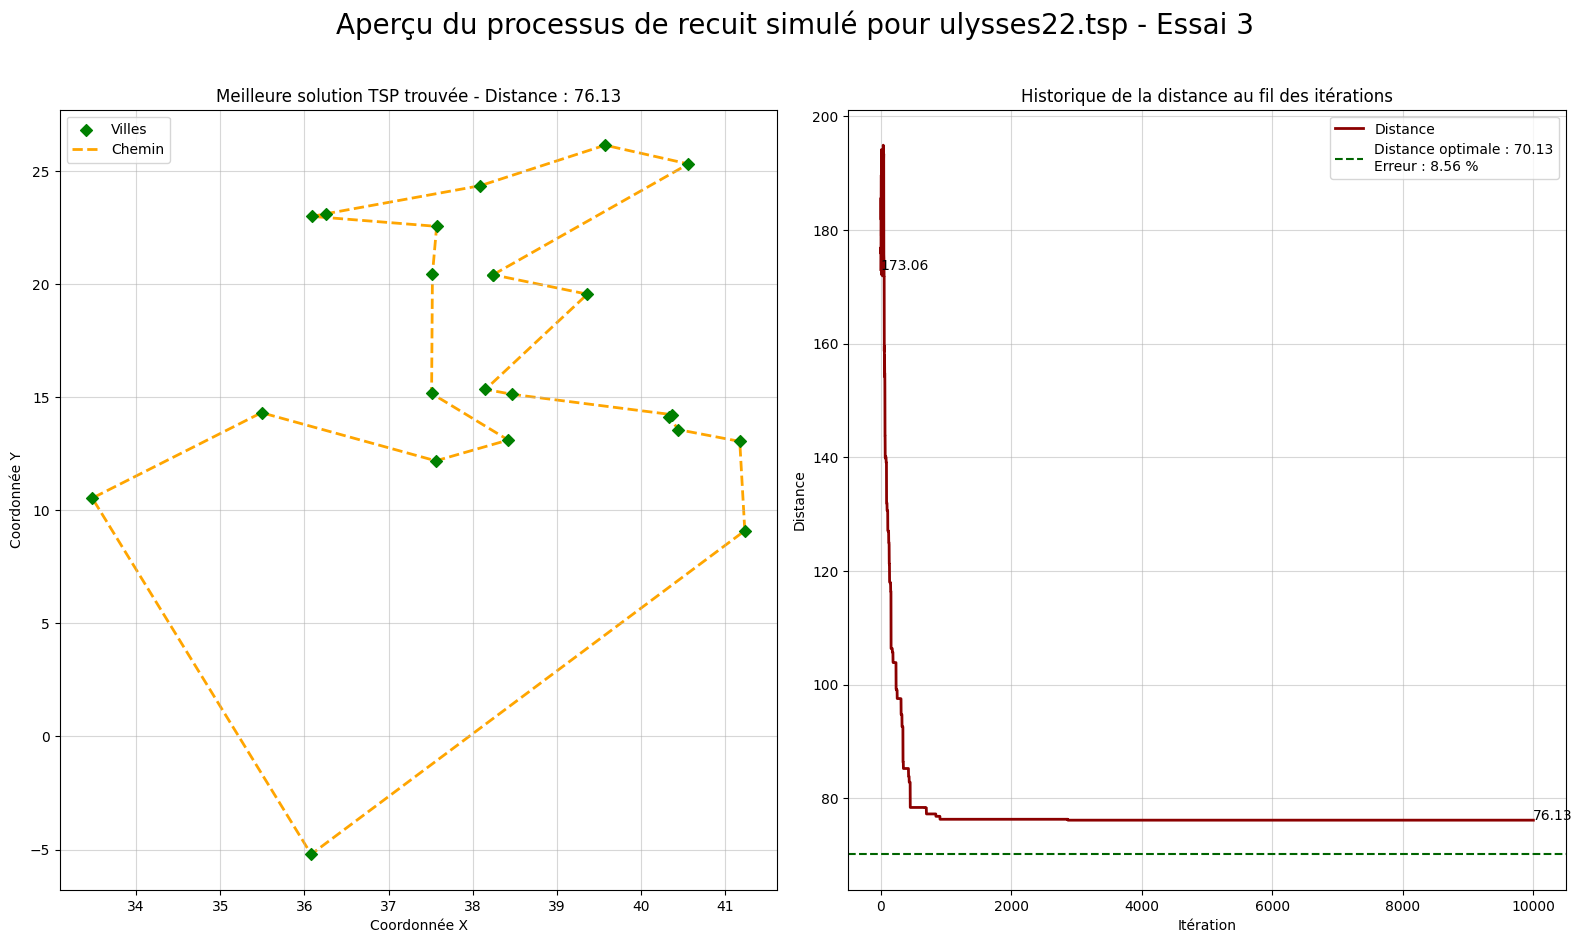

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Meilleure solution trouvée pour le fichier ulysses22.tsp :
(1, [38.24, 20.42])  (3, [40.56, 25.32])  (2, [39.57, 26.15])  (17, [38.09, 24.36])  (4, [36.26, 23.12])  
(18, [36.09, 23.0])  (22, [37.57, 22.56])  (8, [37.52, 20.44])  (15, [35.49, 14.32])  (5, [33.48, 10.54])  
(11, [36.08, -5.21])  (9, [41.23, 9.1])  (10, [41.17, 13.05])  (19, [40.44, 13.57])  (21, [40.37, 14.23])  
(20, [40.33, 14.15])  (7, [38.42, 13.11])  (6, [37.56, 12.19])  (14, [37.51, 15.17])  (13, [38.15, 15.35])  
(12, [38.47, 15.13])  (16, [39.36, 19.56])  (1, [38.24, 20.42])  
Longueur du parcours optimal : 76.01816597362199
Temps d'exécution : 1.8118696212768555 s
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


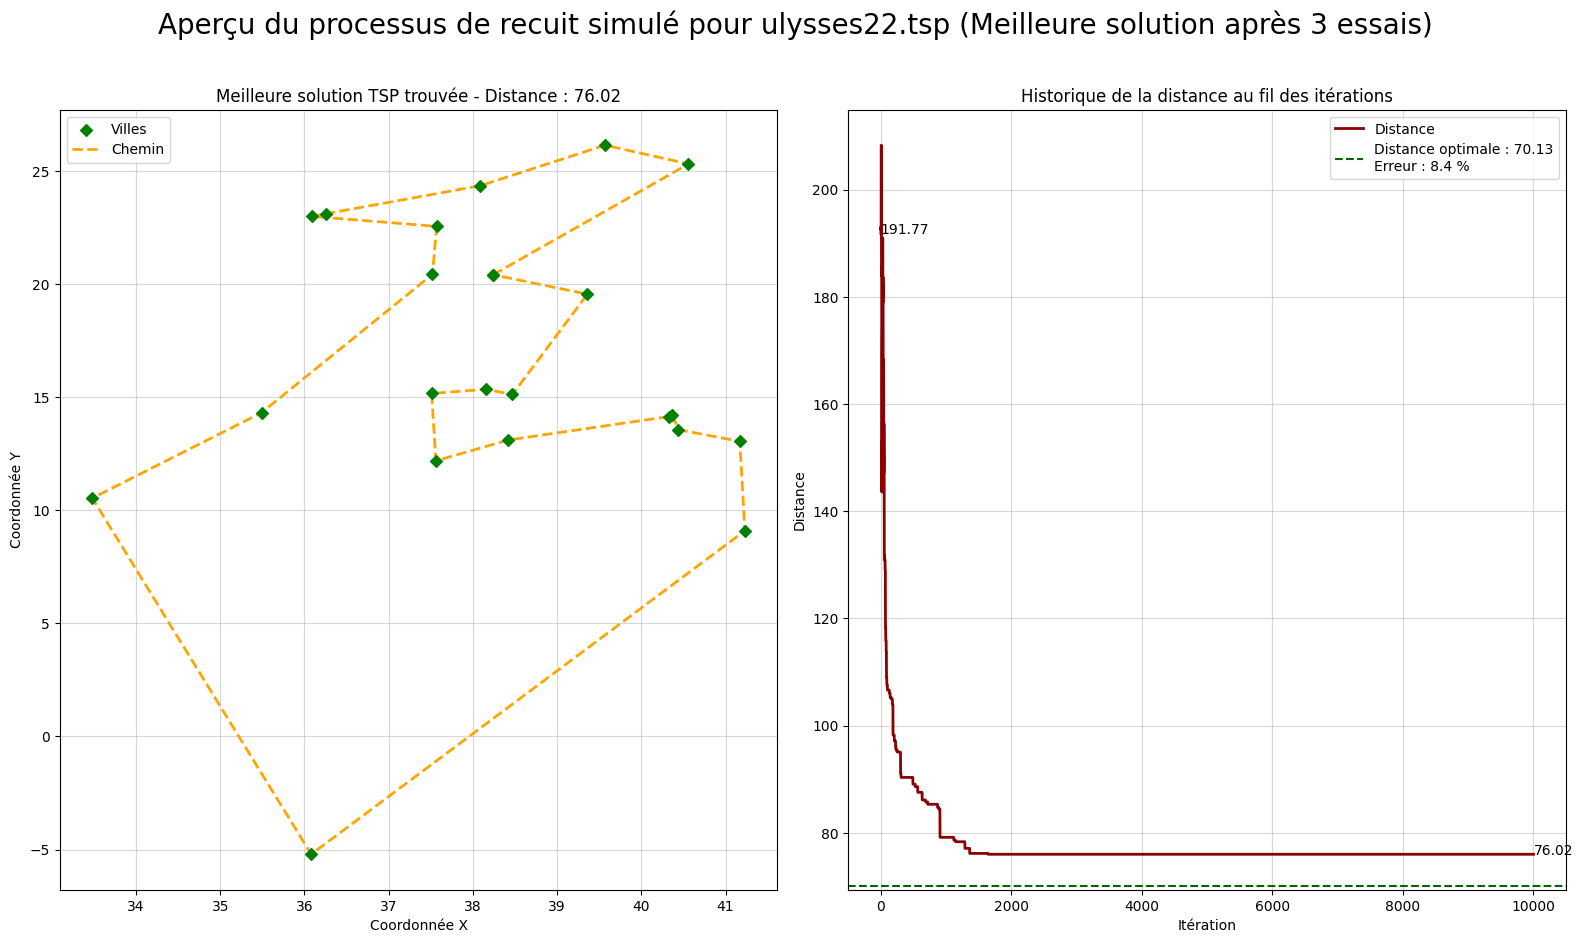

In [ ]:
# Paramètres pour l'exécution du solveur TSP
# temperature = 1000
# cooling_rate = 0.9
# iterations = 10000
# num_trials = 3

# Exécution du solveur TSP
tsp_solver(file_paths, temperature, cooling_rate, iterations, num_trials, optimal_distances)

Entrez la température initiale : 1000
Entrez le taux de refroidissement : 0.1
Entrez le nombre d'itérations : 100000
Entrez le nombre d'essais : 1
ESSAI 1 ----------------------------------------------------------------------------------------------------------------------------------------------------------


<ipython-input-84-99ebe45c785a>:11: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(-delta / temperature)
<ipython-input-84-99ebe45c785a>:11: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-delta / temperature)
<ipython-input-84-99ebe45c785a>:11: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-delta / temperature)


Solution optimale trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (35, [685.0, 595.0])  (34, [700.0, 580.0])  (37, [770.0, 610.0])  (38, [795.0, 645.0])  
(40, [760.0, 650.0])  (39, [720.0, 635.0])  (36, [685.0, 610.0])  (49, [605.0, 625.0])  (32, [575.0, 665.0])  
(45, [555.0, 815.0])  (19, [510.0, 875.0])  (41, [475.0, 960.0])  (8, [525.0, 1000.0])  (9, [580.0, 1175.0])  
(10, [650.0, 1130.0])  (43, [875.0, 920.0])  (33, [1150.0, 1160.0])  (51, [1340.0, 725.0])  (11, [1605.0, 620.0])  
(52, [1740.0, 245.0])  (14, [1530.0, 5.0])  (13, [1465.0, 200.0])  (47, [1170.0, 65.0])  (26, [1215.0, 245.0])  
(27, [1320.0, 315.0])  (28, [1250.0, 400.0])  (12, [1220.0, 580.0])  (25, [975.0, 580.0])  (4, [945.0, 685.0])  
(6, [880.0, 660.0])  (15, [845.0, 680.0])  (5, [845.0, 655.0])  (24, [835.0, 625.0])  (48, [830.0, 610.0])  
(46, [830.0, 485.0])  (44, [700.0, 500.0])  (16, [725.0, 370.0])  (29, [660.0, 180.0])  (50, [595.0, 360.0])  
(20, [560.0, 365.0])  (23, [480.0, 415.0])  (30, 

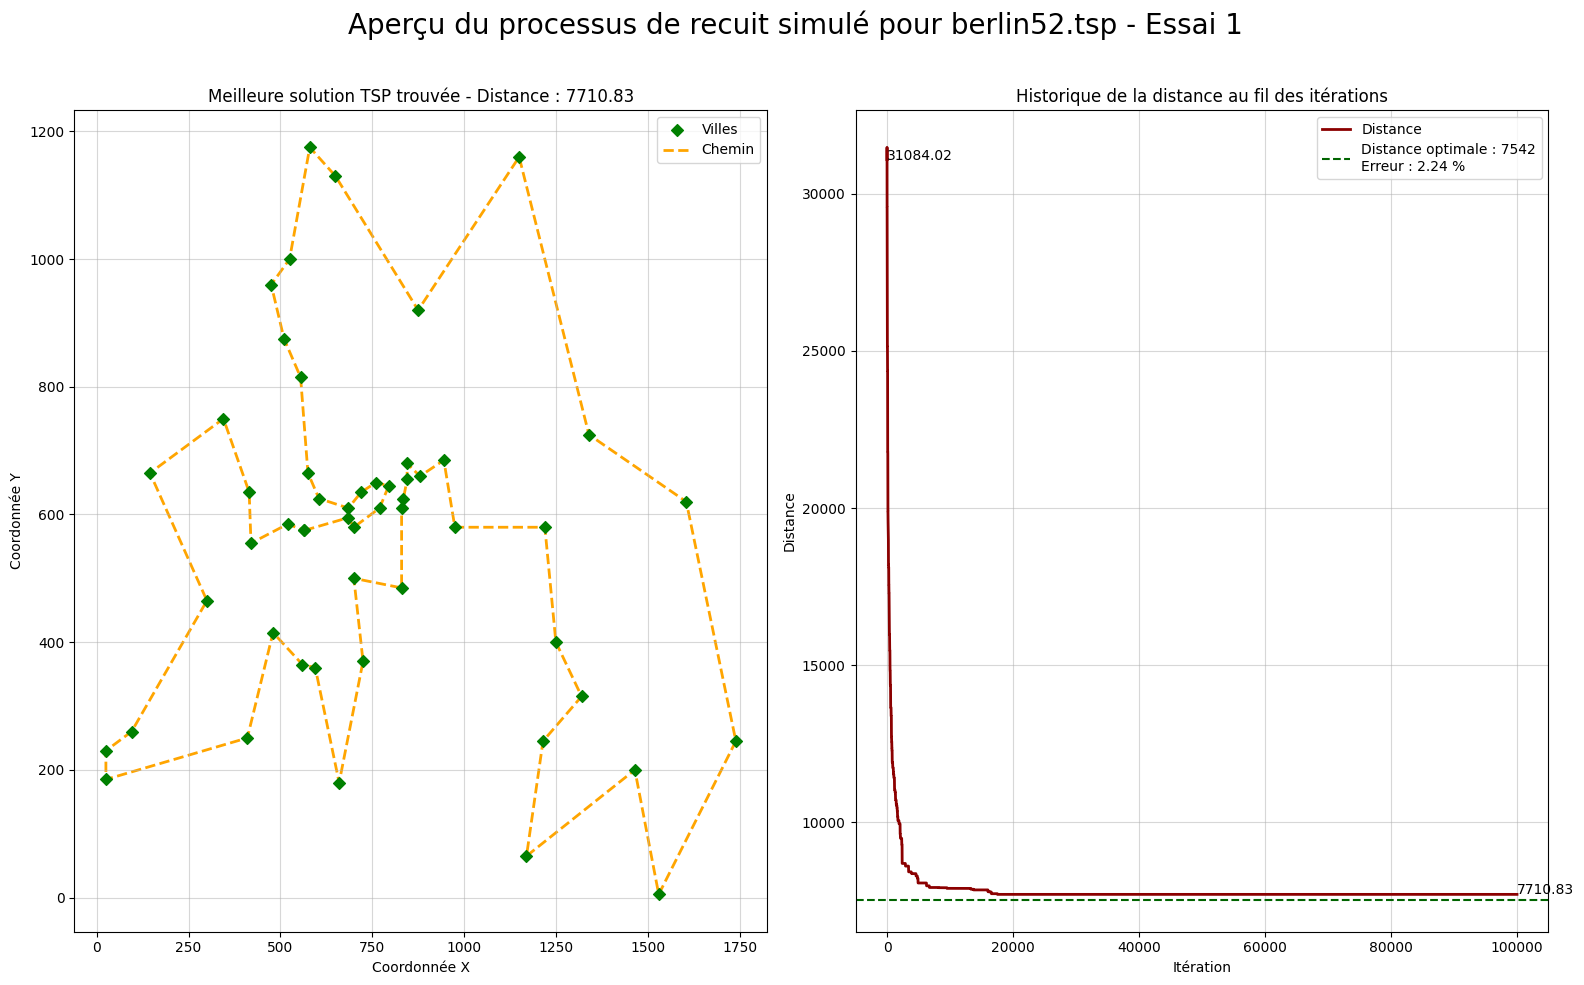

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Meilleure solution trouvée pour le fichier berlin52.tsp :
(1, [565.0, 575.0])  (35, [685.0, 595.0])  (34, [700.0, 580.0])  (37, [770.0, 610.0])  (38, [795.0, 645.0])  
(40, [760.0, 650.0])  (39, [720.0, 635.0])  (36, [685.0, 610.0])  (49, [605.0, 625.0])  (32, [575.0, 665.0])  
(45, [555.0, 815.0])  (19, [510.0, 875.0])  (41, [475.0, 960.0])  (8, [525.0, 1000.0])  (9, [580.0, 1175.0])  
(10, [650.0, 1130.0])  (43, [875.0, 920.0])  (33, [1150.0, 1160.0])  (51, [1340.0, 725.0])  (11, [1605.0, 620.0])  
(52, [1740.0, 245.0])  (14, [1530.0, 5.0])  (13, [1465.0, 200.0])  (47, [1170.0, 65.0])  (26, [1215.0, 245.0])  
(27, [1320.0, 315.0])  (28, [1250.0, 400.0])  (12, [1220.0, 580.0])  (25, [975.0, 580.0])  (4, [945.0, 685.0])  
(6, [880.0, 660.0])  (15, [845.0, 680.0])  (5, [845.0, 655.0])  (24, [835.0, 625.0])  (48, [830

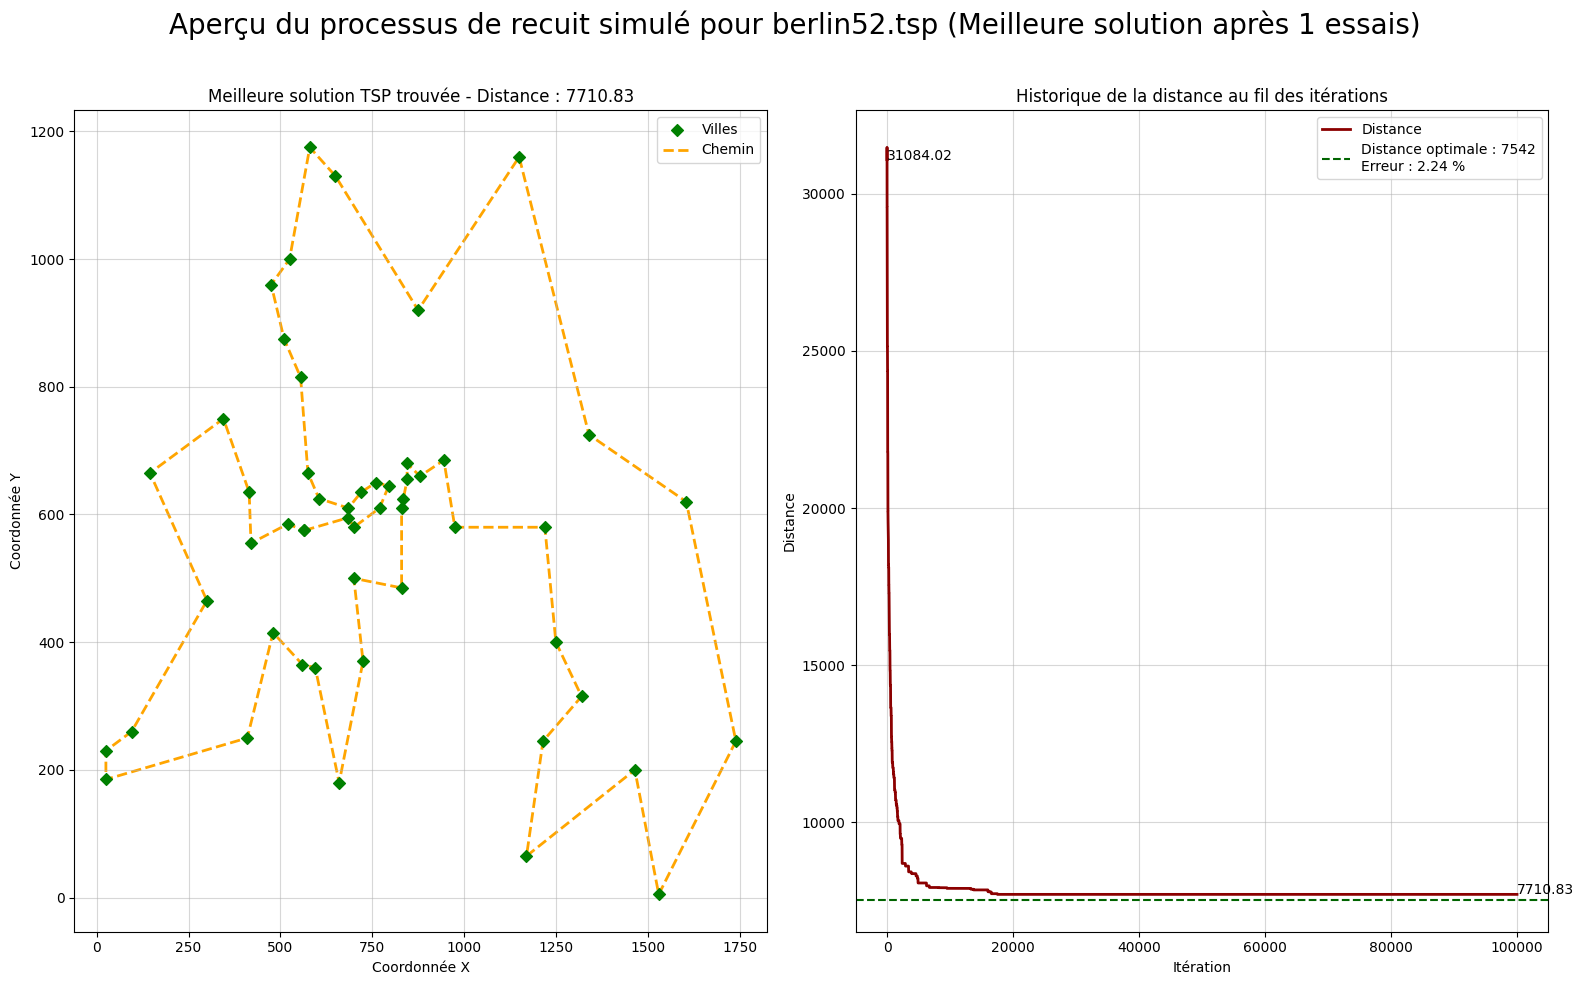

ESSAI 1 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier pr107.tsp :
(1, [8375.0, 4700.0])  (3, [8375.0, 4900.0])  (6, [8575.0, 4900.0])  (5, [8775.0, 4900.0])  (2, [8775.0, 4700.0])  
(63, [15825.0, 4900.0])  (64, [16025.0, 4700.0])  (66, [16025.0, 4900.0])  (67, [16225.0, 4900.0])  (65, [16425.0, 4700.0])  
(68, [16425.0, 4900.0])  (69, [16425.0, 5400.0])  (72, [16425.0, 5600.0])  (71, [16225.0, 5600.0])  (70, [16025.0, 5450.0])  
(73, [16025.0, 5650.0])  (62, [15825.0, 5650.0])  (74, [16025.0, 6200.0])  (61, [15825.0, 6400.0])  (76, [16025.0, 6400.0])  
(77, [16225.0, 6400.0])  (75, [16425.0, 6200.0])  (78, [16425.0, 6400.0])  (80, [16425.0, 7000.0])  (83, [16425.0, 7200.0])  
(82, [16225.0, 7200.0])  (79, [16025.0, 7000.0])  (81, [16025.0, 7200.0])  (60, [15825.0, 7200.0])  (84, [16025.0, 7800.0])  
(59, [15825.0, 8000.0])  (86, [16025.

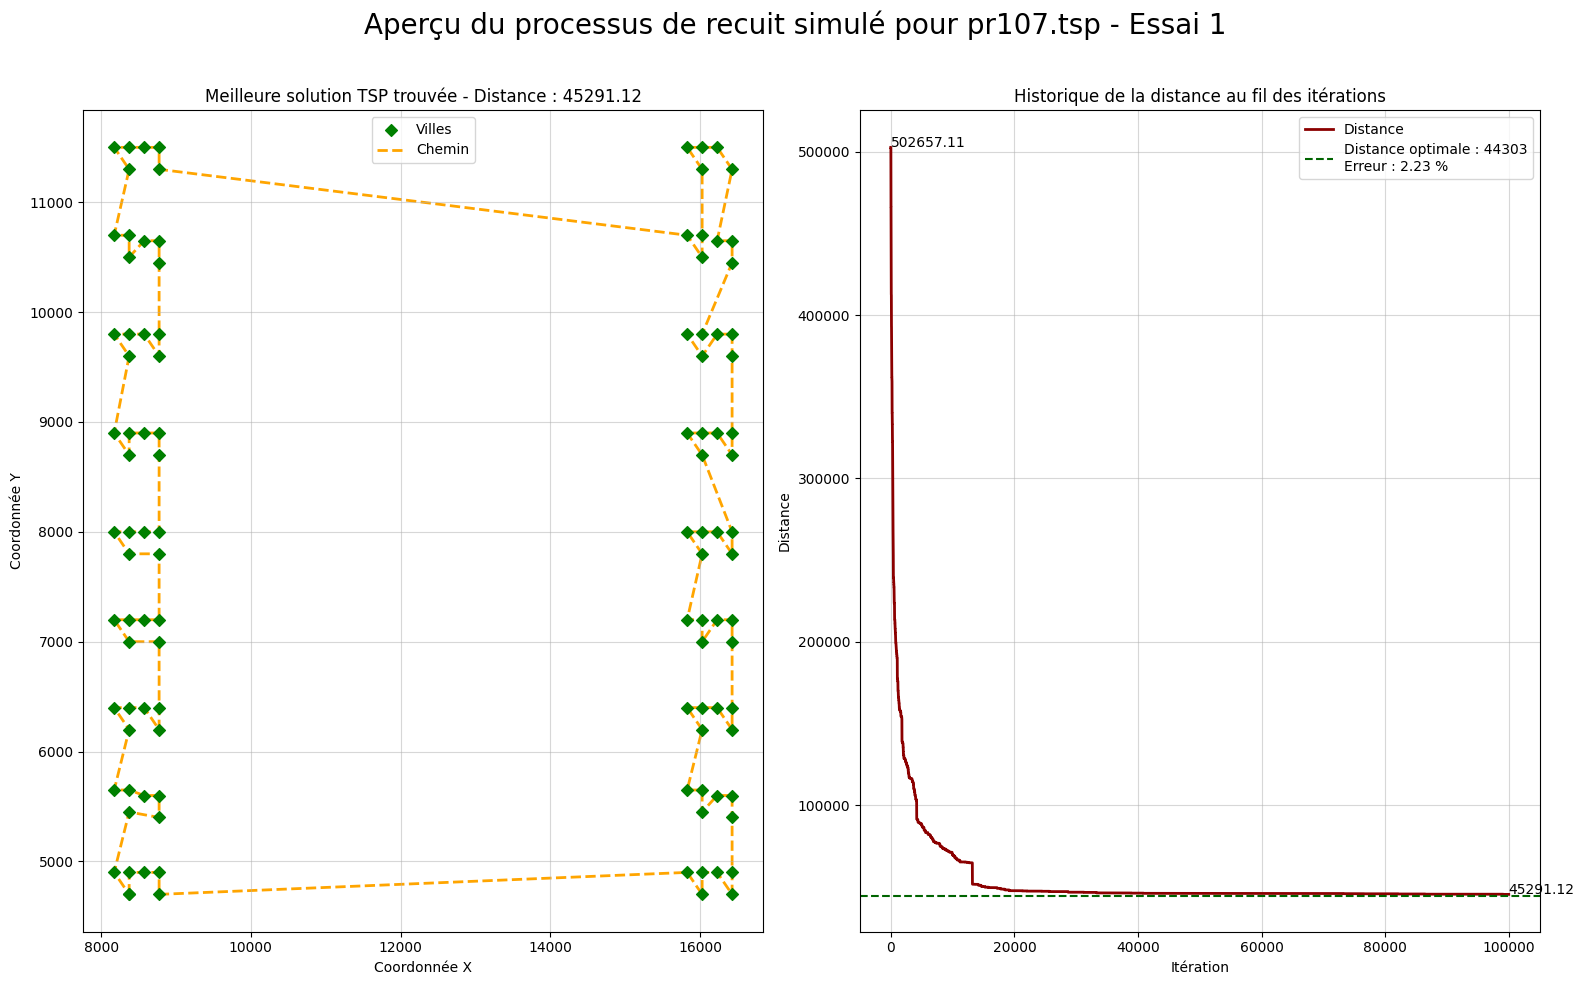

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Meilleure solution trouvée pour le fichier pr107.tsp :
(1, [8375.0, 4700.0])  (3, [8375.0, 4900.0])  (6, [8575.0, 4900.0])  (5, [8775.0, 4900.0])  (2, [8775.0, 4700.0])  
(63, [15825.0, 4900.0])  (64, [16025.0, 4700.0])  (66, [16025.0, 4900.0])  (67, [16225.0, 4900.0])  (65, [16425.0, 4700.0])  
(68, [16425.0, 4900.0])  (69, [16425.0, 5400.0])  (72, [16425.0, 5600.0])  (71, [16225.0, 5600.0])  (70, [16025.0, 5450.0])  
(73, [16025.0, 5650.0])  (62, [15825.0, 5650.0])  (74, [16025.0, 6200.0])  (61, [15825.0, 6400.0])  (76, [16025.0, 6400.0])  
(77, [16225.0, 6400.0])  (75, [16425.0, 6200.0])  (78, [16425.0, 6400.0])  (80, [16425.0, 7000.0])  (83, [16425.0, 7200.0])  
(82, [16225.0, 7200.0])  (79, [16025.0, 7000.0])  (81, [16025.0, 7200.0])  (60, [15825.0, 7200.0])  (84, [16025.0, 7800.0])  
(59, [15825.0, 8000.0])  (

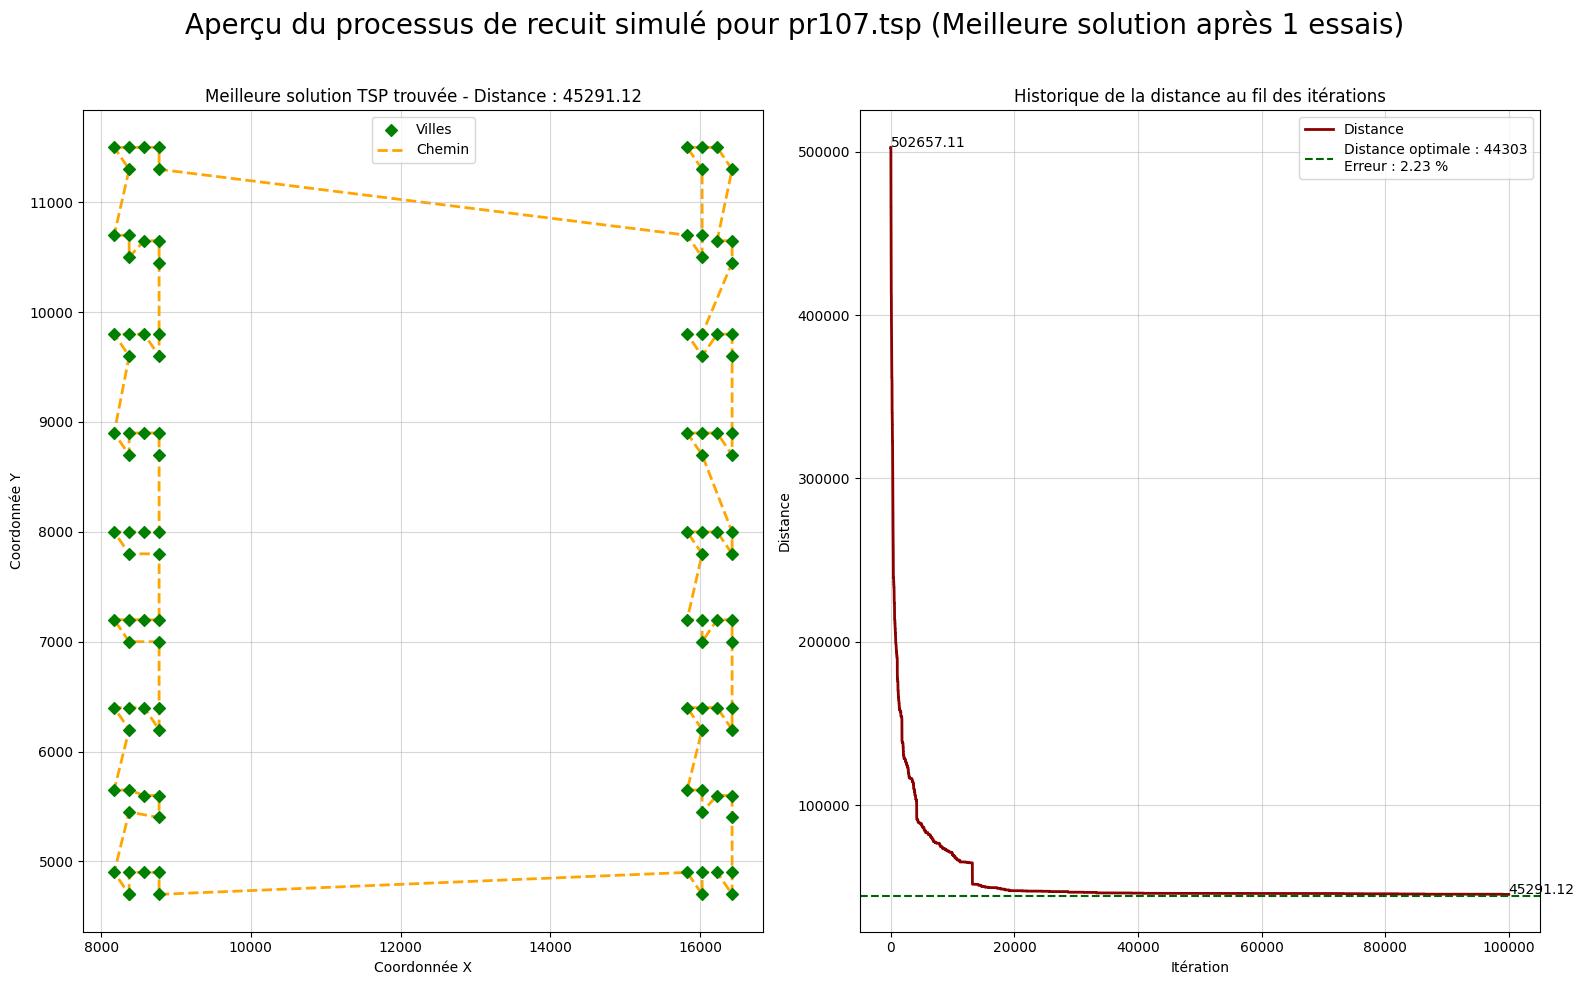

ESSAI 1 ----------------------------------------------------------------------------------------------------------------------------------------------------------
Solution optimale trouvée pour le fichier ulysses22.tsp :
(1, [38.24, 20.42])  (8, [37.52, 20.44])  (22, [37.57, 22.56])  (3, [40.56, 25.32])  (2, [39.57, 26.15])  
(17, [38.09, 24.36])  (4, [36.26, 23.12])  (18, [36.09, 23.0])  (15, [35.49, 14.32])  (5, [33.48, 10.54])  
(11, [36.08, -5.21])  (9, [41.23, 9.1])  (10, [41.17, 13.05])  (19, [40.44, 13.57])  (21, [40.37, 14.23])  
(20, [40.33, 14.15])  (7, [38.42, 13.11])  (6, [37.56, 12.19])  (14, [37.51, 15.17])  (13, [38.15, 15.35])  
(12, [38.47, 15.13])  (16, [39.36, 19.56])  (1, [38.24, 20.42])  
Longueur du parcours optimal : 76.09488402811152
Temps d'exécution : 23.733601331710815


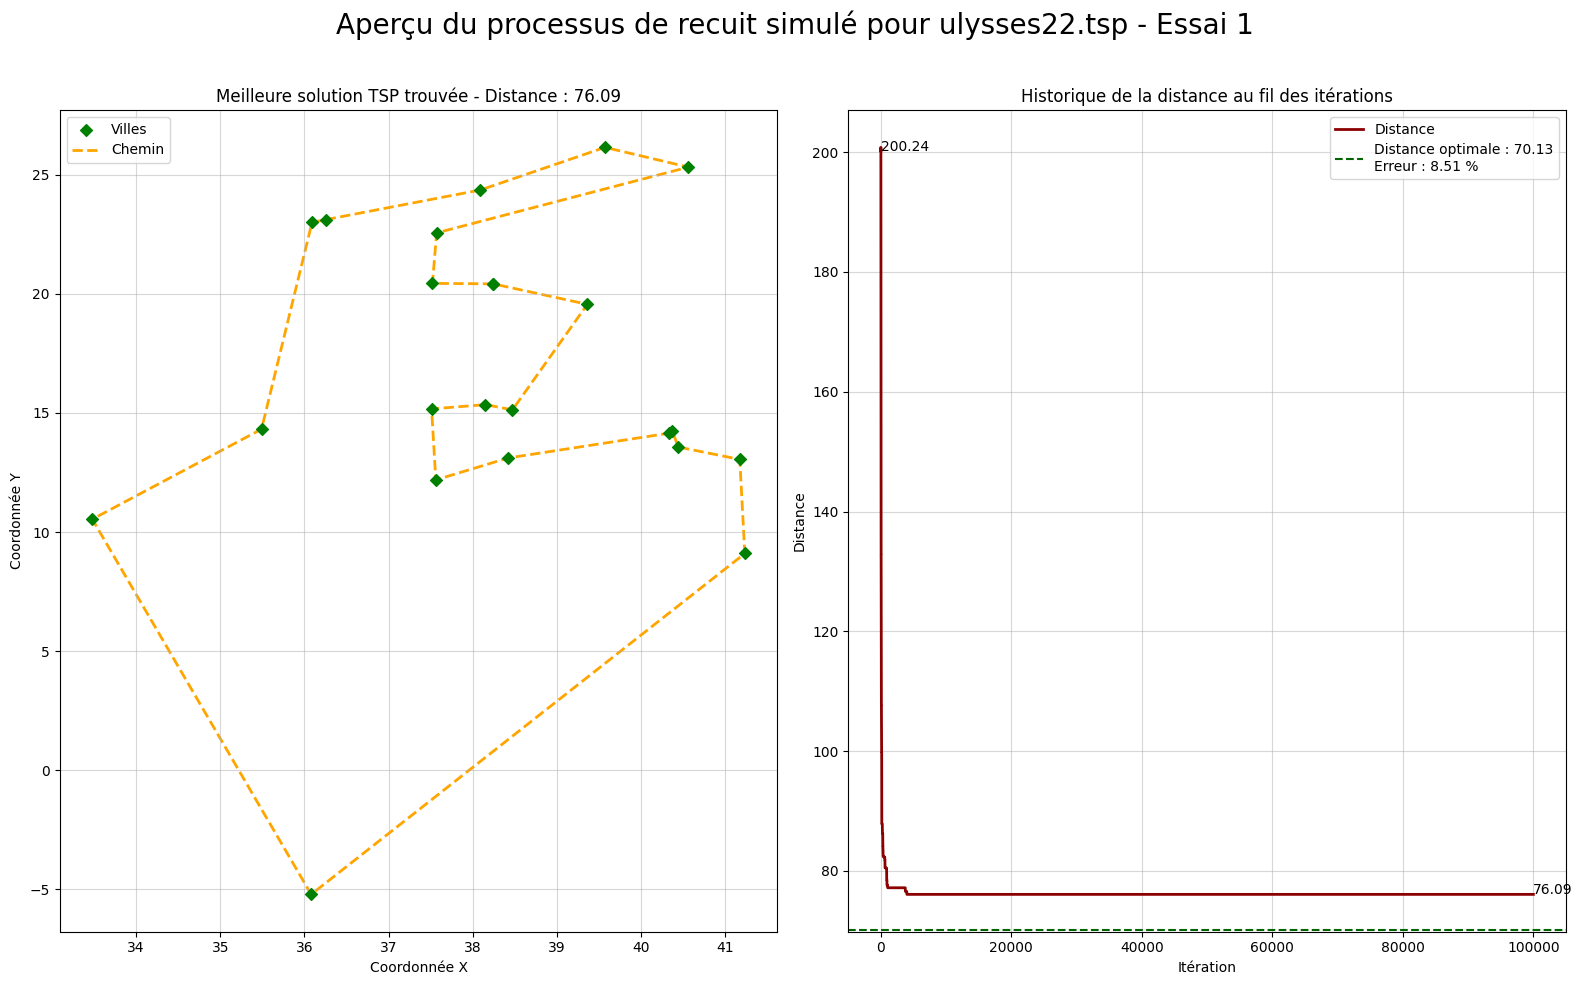

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Meilleure solution trouvée pour le fichier ulysses22.tsp :
(1, [38.24, 20.42])  (8, [37.52, 20.44])  (22, [37.57, 22.56])  (3, [40.56, 25.32])  (2, [39.57, 26.15])  
(17, [38.09, 24.36])  (4, [36.26, 23.12])  (18, [36.09, 23.0])  (15, [35.49, 14.32])  (5, [33.48, 10.54])  
(11, [36.08, -5.21])  (9, [41.23, 9.1])  (10, [41.17, 13.05])  (19, [40.44, 13.57])  (21, [40.37, 14.23])  
(20, [40.33, 14.15])  (7, [38.42, 13.11])  (6, [37.56, 12.19])  (14, [37.51, 15.17])  (13, [38.15, 15.35])  
(12, [38.47, 15.13])  (16, [39.36, 19.56])  (1, [38.24, 20.42])  
Longueur du parcours optimal : 76.09488402811152
Temps d'exécution total : 23.733601331710815
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------


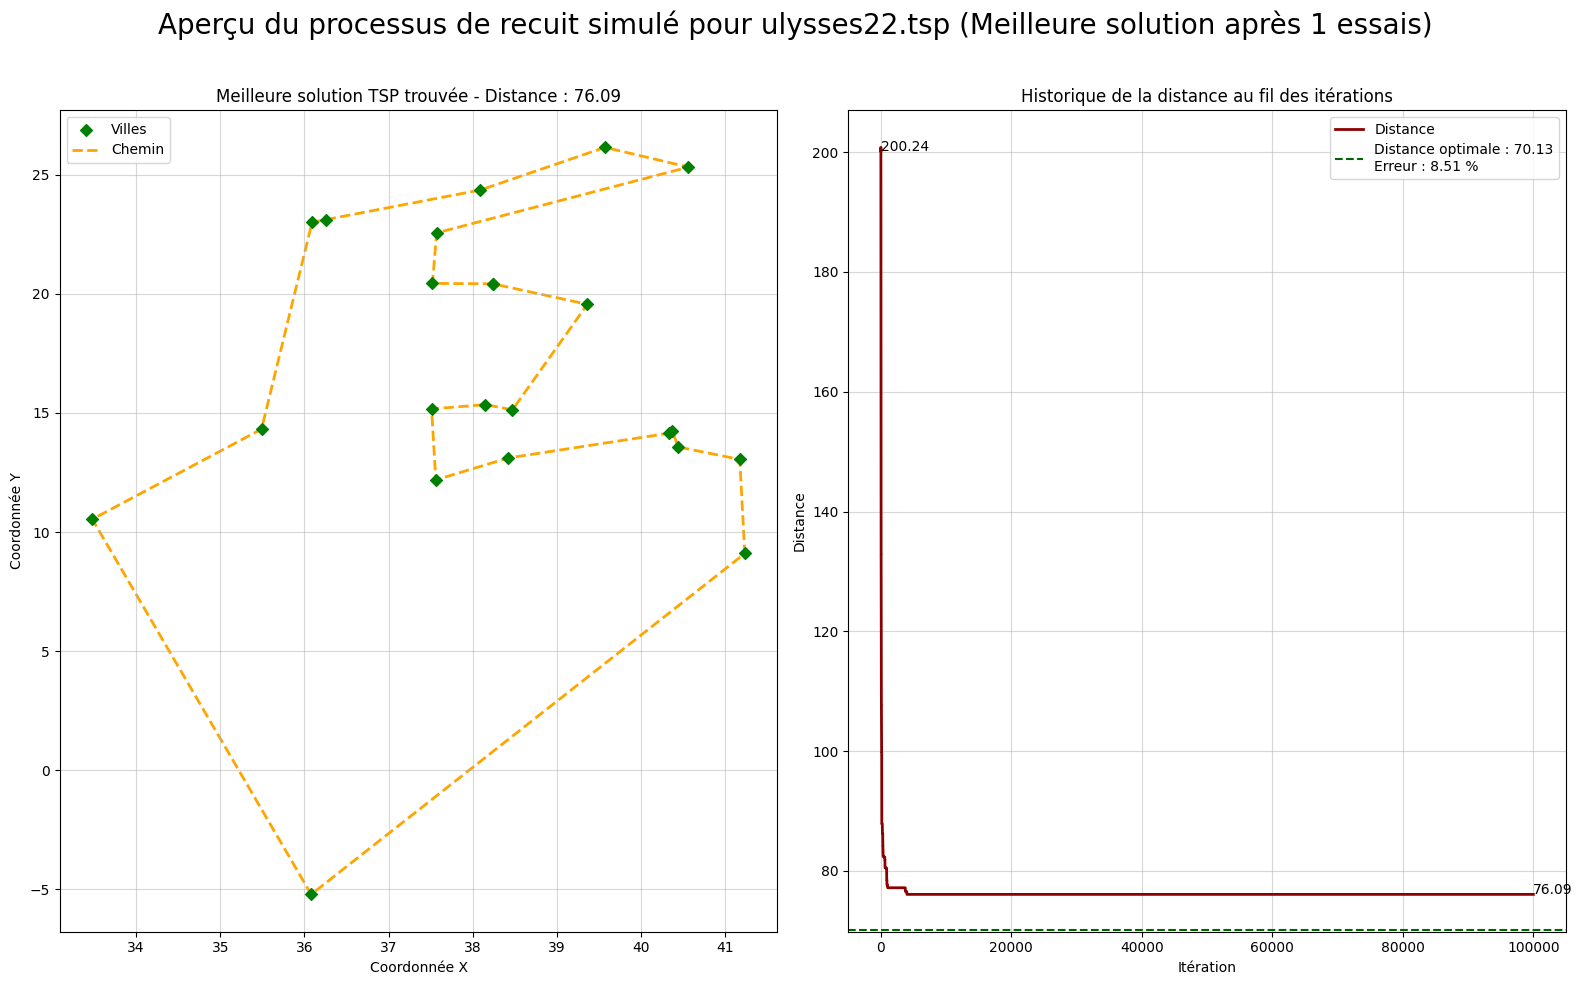

In [ ]:
# Paramètres pour l'exécution du solveur TSP
# temperature = 1000
# cooling_rate = 0.1
# iterations = 100000
# num_trials = 1

# Exécution du solveur TSP
tsp_solver(file_paths, temperature, cooling_rate, iterations, num_trials, optimal_distances)